# Introduction

This notebook is the data science task at The Iconic, see [repo](https://github.com/theiconic/technical-challenges/tree/master/data/data-scientist).

The main task is to infer gender from the given data.

# Summary of EDA



# Summary of Clustering



# Notes

Assertions in try blocks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import os
from dotenv import load_dotenv, find_dotenv
from warnings import warn
from itertools import combinations
import pandas as pd
import numpy as np
from getpass import getpass
from pathlib import (
    Path,
    WindowsPath,
    PosixPath,
)
import sqlite3
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
    silhouette_samples,
)
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn.pipeline import Pipeline

from src.data import (
    utils,
    cleaner,
)
from src.visualization import visualize
from src.features import build_features

In [3]:
%matplotlib inline

# Directories and paths

In [4]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
pwd_hint = os.environ.get("PASSWORD_HINT")

In [5]:
project_dir = Path(dotenv_path).parent
raw_data_dir = project_dir / "data/raw"
reports_dir = project_dir / "reports"
artifacts_dir = reports_dir / "artifacts"

rows_to_drop_path = artifacts_dir / "rows_to_drop.csv"
cols_to_drop_path = artifacts_dir / "cols_to_drop.csv"

In [6]:
raw_data_dir.exists()

True

In [7]:
db_zip_path = raw_data_dir / "test_data.db.zip"
assert db_zip_path.exists()
db_path = raw_data_dir / "test_data.db"

In [8]:
test_data_zip_path = raw_data_dir / "test_data.zip"
assert test_data_zip_path.exists()

# Extract files

Extract the contents into the same directory.

In [9]:
pwd = utils.sha256_text(pwd_hint)

In [10]:
for filename in ["test_data.zip", "test_data.db.zip"]:
    filepath = raw_data_dir / filename
    target_dir = raw_data_dir
    utils.extract_file(filepath=filepath, target_dir=target_dir, pwd=pwd)

# Stage 1 - SQL

1. What percentage of customers who have purchased female items have paid by credit card? 65.4%, see [cell](#question_1)
3. 
We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to? See [cell](#question_2)

In [11]:
pd.options.display.max_columns = 50

In [12]:
con = sqlite3.connect(db_path)
cur = con.cursor()

In [13]:
query = """
SELECT name
FROM sqlite_master
WHERE type = 'table'
"""
cur.execute(query)
table_names = cur.fetchall()
for name in table_names:
    print(name[0])

customers


In [14]:
pd.read_sql_query(sql=query, con=con)

,name
0,customers


In [15]:
table_name = "customers"

In [16]:
query = f"""
SELECT *
FROM {table_name}
"""
pd.read_sql_query(sql=query, con=con)

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,1,0,4,0,0,0,0,17,0,0,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,17,0,3,0,0,0,10,61,0,0,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46274,5b34391ec6fbc0f189cb8d3d88806199,1372,1200,N,18,40,0,0,0,7,2,5,1,1,0,0,36,2,2,17,7,1,8,8,0,4,0,0,0,1,11,0,6,0,0,15,0,3,141.96,1791.33,0.0091,3525.6721,3822.84
46275,198fd2f143f70b149344bcaf7eddee12,646,2976,Y,19,19,1,6,1,2,2,4,1,1,0,0,13,2,4,5,5,2,1,1,1,2,0,0,0,0,12,0,7,0,13,6,0,0,242.87,240.62,0.1210,2092.0177,1383.68
46276,338b5c8ade4af1a562d55d4036710630,1308,23952,N,2,2,0,0,1,2,1,0,1,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,150.00,NaN,0.1500,1500.0000,521.81
46277,2115c065bfc1f3b39e4c87c202e80fa5,1410,30888,Y,14,15,0,2,0,1,2,7,1,0,0,0,15,0,0,13,0,0,0,0,0,0,0,2,0,7,6,0,1,0,0,0,0,14,258.50,254.95,0.1824,3207.6031,712.29


## Analysis Q1

> What percentage of customers who have purchased female items have paid by credit card??

<a id="question_1"/>

In [17]:
query = f"""
SELECT CAST(SUM(CASE WHEN cc_payments > 0 THEN 1 ELSE 0 END) AS FLOAT)/COUNT(1) AS perc_paid_by_cc
FROM {table_name}
WHERE female_items > 0
"""
pd.read_sql_query(sql=query, con=con)

,perc_paid_by_cc
0,0.654288


## Analysis Q2

> We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

In [18]:
query = f"""
WITH male_female_items_cte AS (
    SELECT CASE WHEN male_items > 0 AND female_items = 0 THEN 'male_only'
                WHEN male_items = 0 AND female_items > 0 THEN 'female_only'
                WHEN male_items > 0 AND female_items > 0 THEN 'both'
                END AS item_gender
    FROM {table_name}
)
SELECT item_gender, COUNT(1)
FROM male_female_items_cte
GROUP BY item_gender
"""
pd.read_sql_query(sql=query, con=con)

,item_gender,COUNT(1)
0,None,2106
1,both,7536
2,female_only,26987
3,male_only,9650


Let's find the average spend per item, for those who have bought male items. The campaign is for a luxury brand, the price of individual items are probably going to be much higher than the average price. The following finds users who purchase items with a high individual item price.

In [19]:
query = f"""
WITH total_items_cte AS (
    SELECT *, female_items + male_items + unisex_items AS total_items
    FROM {table_name}
    WHERE male_items > 0
),
ave_price_cte AS (
    SELECT *, revenue / total_items AS item_price
    FROM total_items_cte
)
SELECT 
    MIN(item_price) AS min_item_price
  , MAX(item_price) AS max_item_price
  , avg(item_price) AS avg_item_price
FROM ave_price_cte
"""
pd.read_sql_query(sql=query, con=con)

,min_item_price,max_item_price,avg_item_price
0,0.0,3057.76,106.341304


⭐ Let's set the threshold at $500 for now. This would need to be tuned with more finegrained data.

<a id="question_2"/>

In [23]:
price_threshold = 500
query = f"""
WITH total_items_cte AS (
    SELECT *, female_items + male_items + unisex_items AS total_items
    FROM {table_name}
    WHERE male_items > 0
),
ave_price_cte AS (
    SELECT *, revenue / total_items AS item_price
    FROM total_items_cte
)
SELECT customer_id
FROM ave_price_cte
WHERE item_price > {price_threshold}
"""
customer_ids = pd.read_sql_query(sql=query, con=con)
customer_ids

,customer_id
0,b54e001e1f710ae9fc906f37ae6a68be
1,71ebbc6833c418aada0c971b9001e67f
2,bcc3400c5a6945dc99dd70852419b358
3,e7e702e0c496fe78f7b83754e8f4f4ce
4,3a3336fcd7782ede67dfe151aed1a72c
...,...
111,eab66775ca02dc23e6af0b2d9bed27d6
112,f48f97cbd4a60444f9dbc2610d92ce60
113,6f3df4135c41ad1fcb6e2fb4aced81cc
114,d18445ef6c896ecee088de707f75cbaa


In [26]:
customer_ids.drop_duplicates().to_csv(artifacts_dir / "customer_ids_luxury_brand_candidates.csv")

In [27]:
print(query)


WITH total_items_cte AS (
    SELECT *, female_items + male_items + unisex_items AS total_items
    FROM customers
    WHERE male_items > 0
),
ave_price_cte AS (
    SELECT *, revenue / total_items AS item_price
    FROM total_items_cte
)
SELECT customer_id
FROM ave_price_cte
WHERE item_price > 500



Getting the column order for the next task.

In [376]:
query = f"""
SELECT *
FROM {table_name}
"""
columns = pd.read_sql_query(sql=query, con=con).columns

In [377]:
con.close()

# Stage 2 - CLEAN

In [378]:
data_path = raw_data_dir / "data.json"
assert data_path.exists()

In [379]:
df = pd.read_json(data_path, lines=True).loc[:, columns]
df

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,1,0,4,0,0,0,0,17,0,0,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,17,0,3,0,0,0,10,61,0,0,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46274,5b34391ec6fbc0f189cb8d3d88806199,1372,1200,N,18,40,0,0,0,7,2,5,1,1,0,0,36,2,2,17,7,1,8,8,0,4,0,0,0,1,11,0,6,0,0,15,0,3,141.96,1791.33,0.0091,3525.6721,3822.84
46275,198fd2f143f70b149344bcaf7eddee12,646,2976,Y,19,19,1,6,1,2,2,4,1,1,0,0,13,2,4,5,5,2,1,1,1,2,0,0,0,0,12,0,7,0,13,6,0,0,242.87,240.62,0.1210,2092.0177,1383.68
46276,338b5c8ade4af1a562d55d4036710630,1308,23952,N,2,2,0,0,1,2,1,0,1,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,150.00,NaN,0.1500,1500.0000,521.81
46277,2115c065bfc1f3b39e4c87c202e80fa5,1410,30888,Y,14,15,0,2,0,1,2,7,1,0,0,0,15,0,0,13,0,0,0,0,0,0,0,2,0,7,6,0,1,0,0,0,0,14,258.50,254.95,0.1824,3207.6031,712.29


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46279 entries, 0 to 46278
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               46279 non-null  object 
 1   days_since_first_order    46279 non-null  int64  
 2   days_since_last_order     46279 non-null  int64  
 3   is_newsletter_subscriber  46279 non-null  object 
 4   orders                    46279 non-null  int64  
 5   items                     46279 non-null  int64  
 6   cancels                   46279 non-null  int64  
 7   returns                   46279 non-null  int64  
 8   different_addresses       46279 non-null  int64  
 9   shipping_addresses        46279 non-null  int64  
 10  devices                   46279 non-null  int64  
 11  vouchers                  46279 non-null  int64  
 12  cc_payments               46279 non-null  int64  
 13  paypal_payments           46279 non-null  int64  
 14  afterp

## Profile Reports

`ProfileReport` could take some time to generate. With larger datasets, it would probably better to sample first.

In [381]:
report = ProfileReport(df=df, title="The Iconic", minimal=True)

In [382]:
report.to_file(output_file=reports_dir / "the_iconic_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Days since order

The `days_since_first_order` should be greater or equal to `days_since_last_order`.

In [383]:
if not all(df.loc[:, "days_since_first_order"] > df.loc[:, "days_since_last_order"]):
    print("❌ Not all of `days_since_first_order` > `days_since_last_order`.")

❌ Not all of `days_since_first_order` > `days_since_last_order`.


In [384]:
df[["customer_id", "days_since_first_order", "days_since_last_order"]]

,customer_id,days_since_first_order,days_since_last_order
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528
2,18923c9361f27583d2320951435e4888,2072,144
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272
...,...,...,...
46274,5b34391ec6fbc0f189cb8d3d88806199,1372,1200
46275,198fd2f143f70b149344bcaf7eddee12,646,2976
46276,338b5c8ade4af1a562d55d4036710630,1308,23952
46277,2115c065bfc1f3b39e4c87c202e80fa5,1410,30888


In [385]:
plot_df = pd.melt(frame=df.loc[:, ["customer_id", "days_since_first_order", "days_since_last_order"]],
                  var_name="first_last",
                  value_name="n_days",
                  id_vars="customer_id",)
plot_df

,customer_id,first_last,n_days
0,64f7d7dd7a59bba7168cc9c960a5c60e,days_since_first_order,2091
1,fa7c64efd5c037ff2abcce571f9c1712,days_since_first_order,2082
2,18923c9361f27583d2320951435e4888,days_since_first_order,2072
3,aa21f31def4edbdcead818afcdfc4d32,days_since_first_order,2054
4,668c6aac52ff54d4828ad379cdb38e7d,days_since_first_order,2053
...,...,...,...
92553,5b34391ec6fbc0f189cb8d3d88806199,days_since_last_order,1200
92554,198fd2f143f70b149344bcaf7eddee12,days_since_last_order,2976
92555,338b5c8ade4af1a562d55d4036710630,days_since_last_order,23952
92556,2115c065bfc1f3b39e4c87c202e80fa5,days_since_last_order,30888


C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



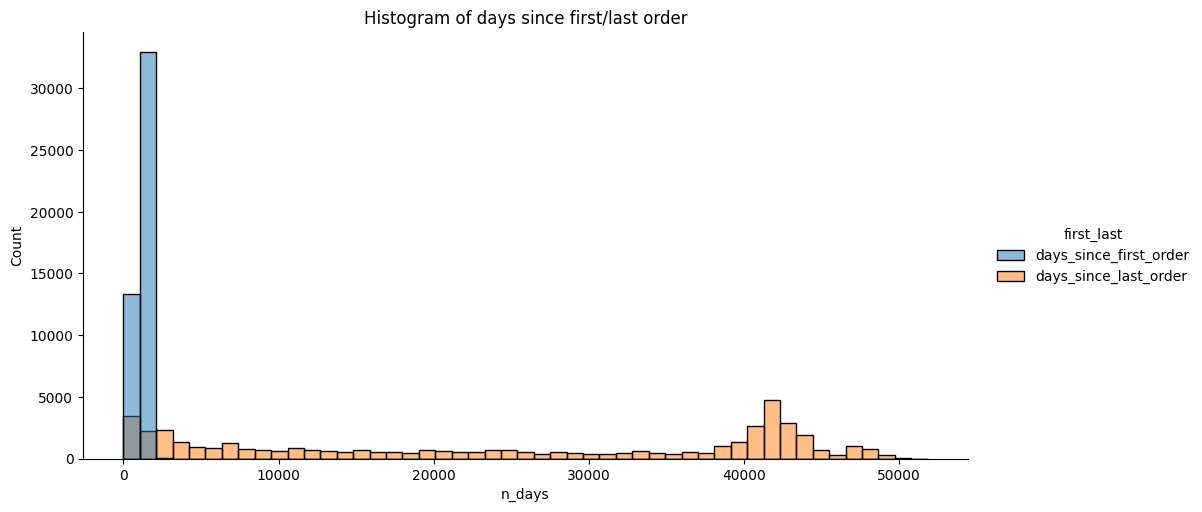

In [386]:
fg = sns.displot(
    data=plot_df,
    x="n_days",
    hue="first_last",
    kind="hist",
    aspect=2,
)
fg.set(title="Histogram of days since first/last order")

There are several observations:
1. The `days_since_last_order` ranges up to 50000 days (~130 years) and beyond, which doesn't make sense. So there might be an encoding error.
2. The values for `days_since_first_order` seem more reasonable.
3. The values where `days_since_first_order` < `days_since_last_order` are incorrect.

Let's see the histograms separately in more granular buckets.

C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



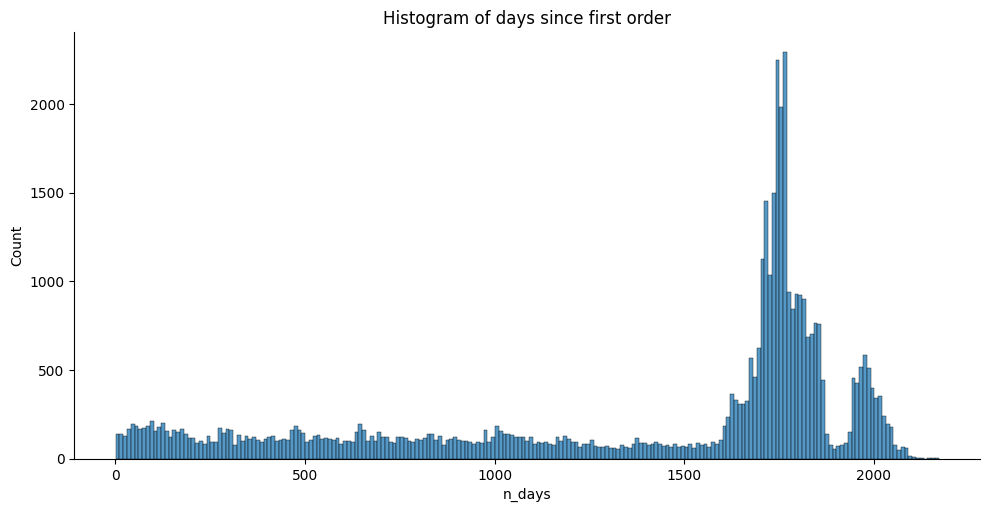

In [387]:
first_last = "first"
col = f"days_since_{first_last}_order"
binwidth = 10
fg = sns.displot(
    data=plot_df.query(f"first_last == @col"),
    x="n_days",
    # hue="first_last",
    kind="hist",
    binwidth=binwidth,
    aspect=2,
)
fg.set(title=f"Histogram of days since {first_last} order")

C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



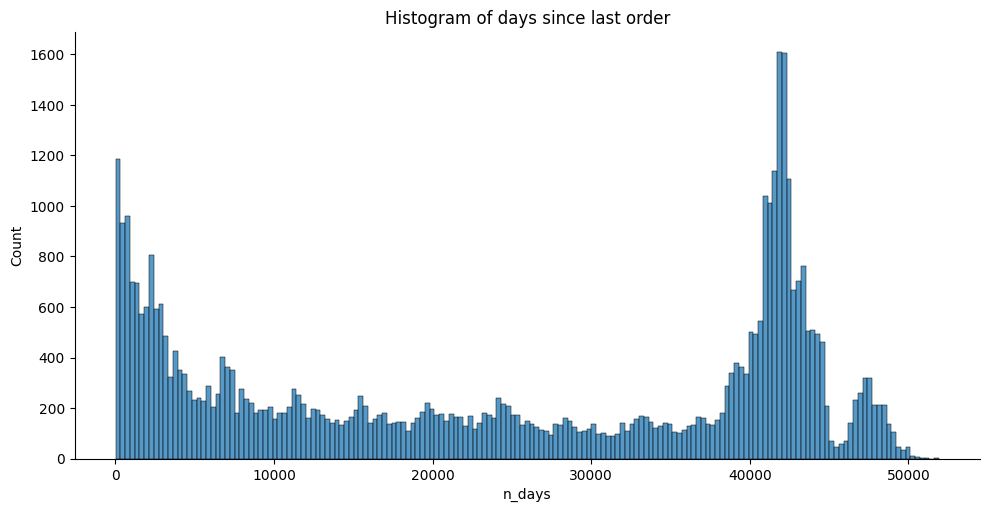

In [388]:
first_last = "last"
col = f"days_since_{first_last}_order"
binwidth = 300
fg = sns.displot(
    data=plot_df.query(f"first_last == @col"),
    x="n_days",
    # hue="first_last",
    kind="hist",
    binwidth=binwidth,
    aspect=2,
)
fg.set(title=f"Histogram of days since {first_last} order")

The distribution shape of `days_since_last_order` after 10000 seems very similar to the `days_since_first_order`.

In [389]:
diff_df = (
    df.query("days_since_first_order < days_since_last_order")
    .assign(diff = lambda df: df.days_since_last_order - df.days_since_first_order)
    .assign(quot = lambda df: df.days_since_last_order / df.days_since_first_order)
    .loc[:, ["customer_id", "days_since_first_order", "days_since_last_order", "diff", "quot"]]
)
diff_df

,customer_id,days_since_first_order,days_since_last_order,diff,quot
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,13581,7.494978
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,47146,23.953262
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,47219,24.000000
5,5f1e0812c41be939d971e34236d4de5b,2044,49056,47012,24.000000
6,d99c815802828fff123971010c99b55b,2042,49008,46966,24.000000
...,...,...,...,...,...
46273,e83fe85868c0e46b03917148937fae18,160,3048,2888,19.050000
46275,198fd2f143f70b149344bcaf7eddee12,646,2976,2330,4.606811
46276,338b5c8ade4af1a562d55d4036710630,1308,23952,22644,18.311927
46277,2115c065bfc1f3b39e4c87c202e80fa5,1410,30888,29478,21.906383


C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



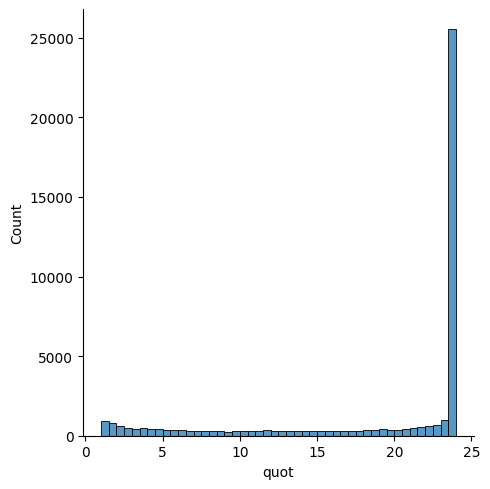

In [390]:
fg = sns.displot(data=diff_df,
                 x="quot",
                 kind="hist")

In [391]:
diff_df.quot.value_counts()

quot
24.000000    22830
12.000000       13
8.000000        12
21.000000       10
1.142857        10
             ...  
23.926456        1
23.104991        1
2.311111         1
22.379115        1
3.994056         1
Name: count, Length: 19239, dtype: int64

In [392]:
diff_df.quot.max()

24.0

Somehow the majority of the `days_since_last_order` is 24 times the `days_since_first_order`, which happens to be the largest multiple too. Perhaps the values are hours since last order. Let's proceed with this assumption now.

⭐ Confirm with data engineering.

In [393]:
df_fixed_last_order = (
    df
    .rename(columns={"days_since_last_order": "hours_since_last_order"})
    .assign(days_since_last_order = lambda df: df.hours_since_last_order / 24)
)
df_fixed_last_order.loc[:, ["customer_id", "days_since_first_order", "days_since_last_order"]]

,customer_id,days_since_first_order,days_since_last_order
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,653.0
1,fa7c64efd5c037ff2abcce571f9c1712,2082,22.0
2,18923c9361f27583d2320951435e4888,2072,6.0
3,aa21f31def4edbdcead818afcdfc4d32,2054,2050.0
4,668c6aac52ff54d4828ad379cdb38e7d,2053,2053.0
...,...,...,...
46274,5b34391ec6fbc0f189cb8d3d88806199,1372,50.0
46275,198fd2f143f70b149344bcaf7eddee12,646,124.0
46276,338b5c8ade4af1a562d55d4036710630,1308,998.0
46277,2115c065bfc1f3b39e4c87c202e80fa5,1410,1287.0


C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



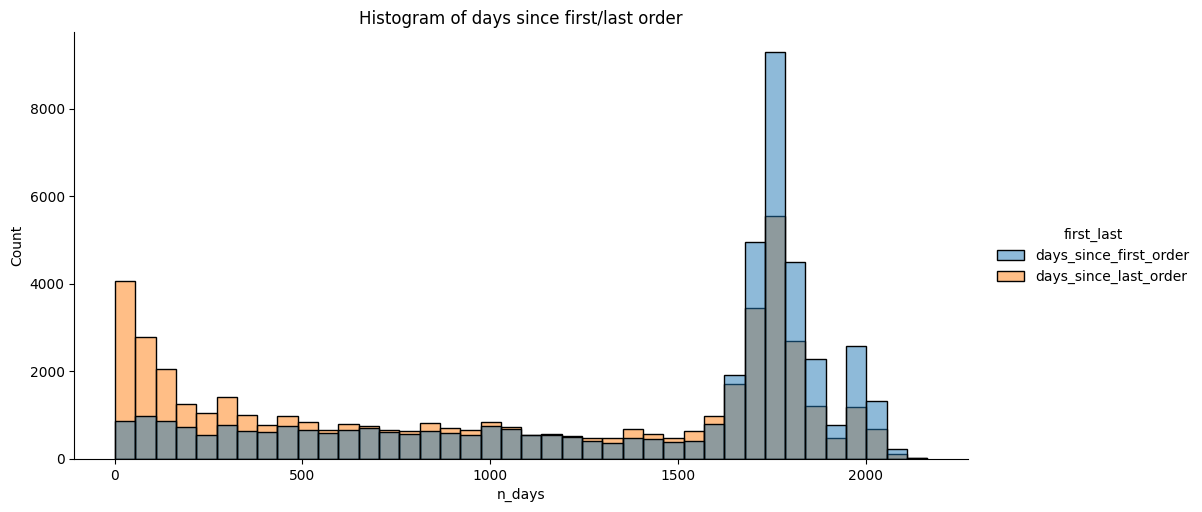

In [394]:
fg = utils.plot_two_histograms(df_fixed_last_order,
                               cols=["days_since_first_order", "days_since_last_order"])
fg.set(title="Histogram of days since first/last order")

## `customer_id` cardinality 

From initial inspection, the `customer_id` should be unique in this table. However, the profile report shows that there are 46030 distinct values, out of a total of 46279 observations.

In [395]:
duplicated_customer_ids = df.customer_id.value_counts().loc[lambda s: s > 1]
duplicated_customer_ids

customer_id
75e39d6810e9dab0767370ff7a593ce2    2
128a11b77e682f7a98082e3bac8246d7    2
345929dbd2c5510c79f491f150e4ac8a    2
c2225a4765e30c52efa215cffd4db618    2
3daf126ead2f6dc908c66b27fe1e93e9    2
                                   ..
d70c9c540881c6fd90c4520ebeef47fa    2
311172fc3465d28d2c0f0f7300078605    2
dd9a051f2ba67d5e41eb2815bd1ef8dd    2
9f8ca50be01eb73c6d8fd527a03814d3    2
41ae01228cfaddc6a390ccdd8be05a66    2
Name: count, Length: 249, dtype: int64

In [396]:
duplicated_customer_ids.describe()

count    249.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0
Name: count, dtype: float64

There are 249 `customer_id`s that are repeated once. Let's check if these duplicated `customer_id`s also have duplicated rows.

In [397]:
df.query("customer_id in @duplicated_customer_ids.index").drop_duplicates()

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
90,31b551b95eba1fef2612fb4c9cbe7057,1994,47856,N,1,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,172.68
354,abca0a05e89b6eb1372e0924365ee8e9,1981,1680,Y,15,23,0,0,0,5,1,0,0,1,0,0,22,0,1,2,8,0,7,7,1,1,0,4,0,0,15,0,0,0,0,2,0,13,576.38,0.00,0.2260,2259.8625,1767.32
456,8634a8d121f4ba5edb5732c1e95a9226,2071,264,Y,30,68,3,1,0,1,2,0,1,0,1,0,64,1,3,58,7,0,0,0,1,1,0,0,1,0,7,0,23,0,0,25,0,5,701.08,0.00,0.0493,493.3673,9209.58
486,772a673b2b2181b921d308b6bac7e62a,2001,48024,N,1,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00
504,7545a5804d642d299dbc8a7ae0d9625c,2003,48072,N,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,22.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24575,6814b87a9ccf58aebc713df7dca5341b,1625,37680,N,2,2,0,0,0,1,1,1,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,105.03,13.63,0.4422,5090.9114,114.96
24813,829c2ed4a5cb395ce8daec2127c2190a,1624,38976,N,1,2,0,1,0,1,1,0,0,1,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,343.64
24845,3e45f0e8680847dca32037b81e0aaae7,1712,10992,Y,6,18,0,1,1,2,3,1,0,1,0,0,18,0,0,11,4,0,1,1,0,2,0,0,0,3,1,0,2,0,0,1,0,5,1889.18,163.59,0.3552,3907.1481,2965.89
24879,71ee6947e30aa529af162e36ee6127af,1710,41040,N,1,2,0,0,0,1,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,58.16,0.00,0.4000,4000.0000,87.24


✔ Dropping the duplicates of the whole table results in a halving of the number of rows, so that means the `customer_id` duplication was also a duplication of the whole row.

## Sum of items

The next candidate for validation is the items being purchased. The assumption is that the more generic column `items` should be equal to `female_items` + `male_items` + `unisex_items`, or greater than (if these three item categories are not exhaustive).

In [398]:
df_item_diff = (
    df
    .assign(item_diff = lambda df: df.loc[:, "items"] - df.loc[:, ["female_items", "male_items", "unisex_items"]].sum(axis="columns"))
)

In [399]:
if not all(df_item_diff.loc[:, "item_diff"] >= 0):
    print("The constituents of `items` are greater than `items`.")

In [400]:
if not all(df_item_diff.loc[:, "item_diff"] == 0):
    print("The constituents of `items` don't add up to `items`.")

✔ The `items` column is consistent with `female_items` + `male_items` + `unisex_items`.

## Total items vs constituents

In [401]:
aggregate_col = "items"
constituent_cols = [
    "wapp_items",
    "mapp_items",
    "wftw_items",
    "mftw_items",
    "wacc_items",
    "macc_items",
    "wspt_items",
    "mspt_items",
    "curvy_items",
    "sacc_items",
]
diff = utils.diff_agg_const(df=df,
                            aggregate_col=aggregate_col,
                            constituent_cols=constituent_cols)

In [402]:
if not all(diff == 0):
    print(f"{constituent_cols} don't add up to {aggregate_col}.")

['wapp_items', 'mapp_items', 'wftw_items', 'mftw_items', 'wacc_items', 'macc_items', 'wspt_items', 'mspt_items', 'curvy_items', 'sacc_items'] don't add up to items.


In [403]:
if not all(diff >= 0):
    print(f"Some customers have more low-level constituents than the total.")

Some customers have more low-level constituents than the total.


❌ The lowest-level constituents don't add up to the total.

## Sum of male items

Similarly, `male_items` should be equal to `mapp_items` + `macc_items` + `mftw_items` + `mspt_items`, or greater than (if the constituents are not exhaustive).

In [404]:
aggregate_col = "male_items"
constituent_cols = ["mapp_items", "macc_items", "mftw_items", "mspt_items"]
diff_col = "item_diff"
assign_dict = {diff_col: lambda df: df.loc[:, aggregate_col] - df.loc[:, constituent_cols].sum(axis="columns")}
df_item_diff = (
    df
    .assign(**assign_dict)
)

In [405]:
if not all(df_item_diff.item_diff >= 0):
    print(f"The sum of {constituent_cols} is more than the `{aggregate_col}`.")

The sum of ['mapp_items', 'macc_items', 'mftw_items', 'mspt_items'] is more than the `male_items`.


In [406]:
df_item_diff.item_diff.value_counts()

item_diff
 0      29397
-1       6113
 1       3025
-2       2370
 2       1115
        ...  
 32         1
 23         1
 31         1
-70         1
 107        1
Name: count, Length: 81, dtype: int64

Try excluding one or more of the constituents. Find out which combination produces the least number of negatives.

### Remove one constituent

In [407]:
diff_df = df.loc[:, [aggregate_col]]
for combo in combinations(constituent_cols, 3):
    diff = df.loc[:, aggregate_col] - df.loc[:, combo].sum(axis="columns")
    col_name = ("_").join([col.split("_")[0] for col in combo])
    diff_df.loc[:, col_name] = diff

In [408]:
diff_df

,male_items,mapp_macc_mftw,mapp_macc_mspt,mapp_mftw_mspt,macc_mftw_mspt
0,2,-1,-1,0,1
1,0,-4,-4,0,-4
2,3,-16,-16,1,-14
3,0,-1,-1,-1,0
4,0,0,0,0,0
...,...,...,...,...,...
46274,2,-7,-7,1,-6
46275,2,-2,-1,-1,0
46276,0,0,0,0,0
46277,0,0,0,0,0


Which of these produces the fewest negatives.

In [409]:
diff_df.lt(0).sum()

male_items            0
mapp_macc_mftw    10956
mapp_macc_mspt     9453
mapp_mftw_mspt     2761
macc_mftw_mspt     9443
dtype: int64

### Remove two constituents

In [410]:
diff_df = df.loc[:, [aggregate_col]]
for combo in combinations(constituent_cols, 2):
    diff = df.loc[:, aggregate_col] - df.loc[:, combo].sum(axis="columns")
    col_name = ("_").join([col.split("_")[0] for col in combo])
    diff_df.loc[:, col_name] = diff

In [411]:
diff_df

,male_items,mapp_macc,mapp_mftw,mapp_mspt,macc_mftw,macc_mspt,mftw_mspt
0,2,-1,0,0,1,1,2
1,0,-4,0,0,-4,-4,0
2,3,-16,1,1,-14,-14,3
3,0,-1,-1,-1,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
46274,2,-7,1,1,-6,-6,2
46275,2,-1,-1,0,0,1,1
46276,0,0,0,0,0,0,0
46277,0,0,0,0,0,0,0


Which of these produces the fewest negatives.

In [412]:
diff_df.lt(0).sum()

male_items       0
mapp_macc     9157
mapp_mftw     2431
mapp_mspt      807
macc_mftw     9197
macc_mspt     8117
mftw_mspt     1489
dtype: int64

The results don't seem convincing. 

**Conclusion**

The following are consistent with each other:
1. `items`
2. `male_items`
3. `female_items`
4. `unisex_items`

Which gives more credibility to their correctness. Since none of the male item constituents are consistent with `male_items`, then disregard the constituent columns.

In [413]:
reason = f"The male item constituents don't add up to the `{aggregate_col}`"
utils.write_cols_to_drop(cols=constituent_cols, 
                         filepath=cols_to_drop_path, 
                         reason=reason,)

## Sum of female items

Similarly, `women_items` should equal `wapp_items` + `wacc_items` + `wftw_items` + `wspt_items`.

In [414]:
aggregate_col = "female_items"
constituent_cols = ["wapp_items", "wacc_items", "wftw_items", "wspt_items"]
diff_col = "item_diff"
assign_dict = {diff_col: lambda df: df.loc[:, aggregate_col] - df.loc[:, constituent_cols].sum(axis="columns")}
df_item_diff = (
    df
    .assign(**assign_dict)
)

In [415]:
if not all(df_item_diff.item_diff >= 0):
    print(f"The sum of {constituent_cols} is more than `{aggregate_col}`.")

The sum of ['wapp_items', 'wacc_items', 'wftw_items', 'wspt_items'] is more than `female_items`.


In [416]:
df_item_diff.loc[:, [aggregate_col] + constituent_cols + [diff_col]]

,female_items,wapp_items,wacc_items,wftw_items,wspt_items,item_diff
0,46,35,1,7,4,-1
1,24,16,4,2,3,-1
2,147,96,17,33,3,-2
3,0,1,0,0,0,-1
4,1,0,0,1,0,0
...,...,...,...,...,...,...
46274,36,17,8,7,4,0
46275,13,5,1,5,2,0
46276,2,2,0,0,0,0
46277,15,13,0,0,0,2


In [417]:
df_item_diff.item_diff.value_counts()

item_diff
 0      40445
-1       2267
 1       1397
 2        622
-2        440
 3        287
 4        186
-3        135
 5         88
 6         78
-4         59
 7         37
 9         32
 8         27
 10        23
 11        18
-5         18
-6         14
 14         9
 15         8
 17         7
-7          6
 19         6
 24         5
 13         5
 18         4
 16         4
 22         4
-9          4
 12         4
 25         3
-8          3
 20         3
-10         3
-14         2
-13         2
 23         2
 38         2
 31         1
-17         1
 116        1
 32         1
 33         1
 41         1
 26         1
 39         1
 27         1
 42         1
 36         1
-32         1
-12         1
 28         1
 30         1
 62         1
 29         1
 21         1
-11         1
 37         1
Name: count, dtype: int64

### Remove one constituent

In [418]:
diff_df = df.loc[:, [aggregate_col]]
for combo in combinations(constituent_cols, 3):
    diff = df.loc[:, aggregate_col] - df.loc[:, combo].sum(axis="columns")
    col_name = ("_").join([col.split("_")[0] for col in combo])
    diff_df.loc[:, col_name] = diff

In [419]:
diff_df

,female_items,wapp_wacc_wftw,wapp_wacc_wspt,wapp_wftw_wspt,wacc_wftw_wspt
0,46,3,6,0,34
1,24,2,1,3,15
2,147,1,31,15,94
3,0,-1,-1,-1,0
4,1,0,1,0,0
...,...,...,...,...,...
46274,36,4,7,8,17
46275,13,2,5,1,5
46276,2,0,0,0,2
46277,15,2,2,2,15


In [420]:
diff_df.lt(0).sum()

female_items         0
wapp_wacc_wftw    2212
wapp_wacc_wspt     880
wapp_wftw_wspt    1618
wacc_wftw_wspt    1287
dtype: int64

### Remove two constituents

In [421]:
diff_df = df.loc[:, [aggregate_col]]
for combo in combinations(constituent_cols, 2):
    diff = df.loc[:, aggregate_col] - df.loc[:, combo].sum(axis="columns")
    col_name = ("_").join([col.split("_")[0] for col in combo])
    diff_df.loc[:, col_name] = diff

In [422]:
diff_df

,female_items,wapp_wacc,wapp_wftw,wapp_wspt,wacc_wftw,wacc_wspt,wftw_wspt
0,46,10,4,7,38,41,35
1,24,4,6,5,18,17,19
2,147,34,18,48,97,127,111
3,0,-1,-1,-1,0,0,0
4,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...
46274,36,11,12,15,21,24,25
46275,13,7,3,6,7,10,6
46276,2,0,0,0,2,2,2
46277,15,2,2,2,15,15,15


In [423]:
diff_df.lt(0).sum()

female_items       0
wapp_wacc        674
wapp_wftw       1261
wapp_wspt        403
wacc_wftw       1086
wacc_wspt        465
wftw_wspt        804
dtype: int64

The results don't seem convincing. 

**Conclusion**

The following are consistent with each other:
1. `items`
2. `male_items`
3. `female_items`
4. `unisex_items`

Which gives more credibility to their correctness. Since none of the female item constituents are consistent with `female_items`, then disregard the constituent columns.

In [424]:
reason = f"The women item constituents don't add up to the `{aggregate_col}`"
utils.write_cols_to_drop(cols=constituent_cols, 
                         filepath=cols_to_drop_path, 
                         reason=reason)

## Orders vs items

There shouldn't be more orders than items.

In [425]:
diff = df.loc[:, "orders"] - df.loc[:, "items"]

In [426]:
if not diff.min() <= 0:
    warn("There are more orders than items.")

## Orders vs cancellation

`orders` should be >= `cancels`.

In [427]:
diff = df.loc[:, "orders"] - df.loc[:, "cancels"]

In [428]:
if not diff.min() >= 0:
    warn("There are more cancels than orders.")

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\2930520538.py:2: UserWarning:

There are more cancels than orders.



In [429]:
invalid_returns = diff.loc[lambda s: s < 0]
invalid_returns

8724    -1
19888   -1
25611   -1
25854   -1
33382   -2
41213   -4
dtype: int64

In [430]:
invalid_df = df.iloc[invalid_returns.index].loc[:, ["customer_id", "orders", "cancels"]]
invalid_df

,customer_id,orders,cancels
8724,c6c98904a065185674f114f6d04bc302,1,2
19888,e2a692f5b9d6cd91119c9d88340fbf68,1,2
25611,f258621a4186ce7bea4ab138ad5d100d,1,2
25854,f93b55212d076942d9c9809d9f26cff8,1,2
33382,abc9d7545694a097ff915ed2e09b554d,2,4
41213,fb70d678faee68f0b22f77e69258a72c,1,5


⭐ Check with data engineering.

* The definition of `orders` is "Number of orders"
* The definition of `cancels` is "Number of cancellations - when the order is cancelled after being placed"

If `orders` is recorded when the order is placed, then there is an inconsistency with `orders` and `cancels`.

In [431]:
reason = "There are more cancels than orders."
utils.write_customer_ids_to_drop(
    df=invalid_df,
    filepath=rows_to_drop_path,
    reason=reason,
)

## Items vs returns

While `returns` can be greater than `orders`, because an order can have multiple items and the items are returned separately, `returns` can't be greater than `items`.

In [432]:
diff = df.loc[:, "items"] - df.loc[:, "returns"]

In [433]:
if not diff.min() >= 0:
    warn("There are more `returns` than `items`.")

✔ There aren't more returns than items.

## Payments vs orders

In [434]:
aggregate_col = "orders"
constituent_cols = [
    "cc_payments",
    "paypal_payments",
    "afterpay_payments",
    "apple_payments",
]
diff = utils.diff_agg_const(df=df,
                            aggregate_col=aggregate_col,
                            constituent_cols=constituent_cols)

In [435]:
if not all(diff == 0):
    warn(f"{constituent_cols} don't add up to `{aggregate_col}`.")

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\984614505.py:2: UserWarning:

['cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments'] don't add up to `orders`.



In [436]:
if not all(diff >= 0):
    warn(f"{constituent_cols} add up to more than `{aggregate_col}`.")

In [437]:
df.loc[:, constituent_cols].max()

cc_payments          1
paypal_payments      1
afterpay_payments    1
apple_payments       1
dtype: int64

⭐ These columns seem to be indicators rather than the described "number of payments". Nonetheless, they would still be useful for modelling.

## Vouchers vs average discounts used

In [438]:
condition_1 = "vouchers > 0 and average_discount_used == 0"
condition_2 = "vouchers == 0 and average_discount_used > 0"
invalid_df = df.query(f"({condition_1}) or ({condition_2})")
invalid_df.loc[:, ["vouchers", "average_discount_used"]]

,vouchers,average_discount_used
1,0,1404.0966
6,0,6983.3887
17,0,5019.3247
28,0,5325.1318
29,0,5970.6045
...,...,...
46268,0,5376.5101
46270,0,2250.0000
46271,0,6000.1760
46276,0,1500.0000


In [439]:
invalid_df.loc[:, "vouchers"].value_counts()

vouchers
0    17870
1      123
2        6
3        1
Name: count, dtype: int64

In [440]:
invalid_df.loc[lambda df: df["vouchers"] == 0, ["vouchers", "average_discount_used"]]

,vouchers,average_discount_used
1,0,1404.0966
6,0,6983.3887
17,0,5019.3247
28,0,5325.1318
29,0,5970.6045
...,...,...
46268,0,5376.5101
46270,0,2250.0000
46271,0,6000.1760
46276,0,1500.0000


In [441]:
invalid_df.loc[lambda df: df["vouchers"] > 0, ["customer_id", "vouchers", "average_discount_used"]]

,customer_id,vouchers,average_discount_used
2377,5f0825d7f955a5b3ffd31a9ef68a44c4,1,0.0
2464,635bfc6f8fb397a0fb511aa3c5e6e686,1,0.0
2689,c256e89d1d70be688f48c10ac969e0c3,1,0.0
2820,979663a49b815f4fe1b287659678f463,1,0.0
3083,f7e06dbdd21fd7efd7c3c5127643f801,1,0.0
...,...,...,...
40968,ac5ff3044b7096694e733436f37c78bf,1,0.0
43095,70f9ccc277defcb2c7138a3b2dde5b5f,1,0.0
43347,ee75019bd786a910cbe4eed937b52c83,1,0.0
43848,3d073003fd9c70ffcd1a47d79e381797,1,0.0


* ❌ There are `customer_id`s who did not use vouchers, but somehow got a discount (not on offer)
* ❗ There are `customer_id`s who used vouchers, but did not get any discount. Potential system bug; vouchers with zero discounts should not exist.

⭐ There are quite a lot of zero `vouchers` with non-zero `average_discount_used`. For now, remove the `vouchers` column rather than removing the inconsistent rows.

In [442]:
reason = "`vouchers` is not consistent with `average_discount_used`."
utils.write_cols_to_drop(
    cols=["vouchers"],
    filepath=cols_to_drop_path,
    reason=reason,
)

## Revenue vs average discounts used

In [443]:
diff = df.loc[:, "revenue"] - df.loc[:, "average_discount_used"]

In [444]:
if not all(diff.gt(0)):
    print("`revenue` is smaller than the `average_discount_used`.")

`revenue` is smaller than the `average_discount_used`.


In [445]:
cols = [
    "revenue",
    "redpen_discount_used",
    "coupon_discount_applied",
    "average_discount_onoffer",
    "average_discount_used",
]
df.loc[:, cols]

,revenue,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used
0,6946.34,4554.39,248.65,0.3364,3584.4818
1,5329.28,629.03,0.00,0.1404,1404.0966
2,14133.87,6269.71,107.92,0.1851,1899.7270
3,143.64,0.00,90.90,0.0000,3875.6715
4,0.00,0.00,0.00,0.0000,0.0000
...,...,...,...,...,...
46274,3822.84,141.96,1791.33,0.0091,3525.6721
46275,1383.68,242.87,240.62,0.1210,2092.0177
46276,521.81,150.00,NaN,0.1500,1500.0000
46277,712.29,258.50,254.95,0.1824,3207.6031


In [446]:
quot = df.loc[:, "average_discount_used"] / df.loc[:, "average_discount_onoffer"]

In [447]:
quot.value_counts()

inf             3612
1.000000e+04    1193
1.000000e+04     342
9.999324e+03     128
1.000033e+04     103
                ... 
9.999941e+03       1
1.000168e+04       1
9.998425e+03       1
1.195199e+04       1
9.995765e+03       1
Name: count, Length: 23975, dtype: int64

A large proportion of the quotient above are near 10000.

⭐ Divide `average_discount_used` by 10000.

In [448]:
diff = df.loc[:, "revenue"] - df.loc[:, "average_discount_used"] / 10000

In [449]:
if not all(diff.gt(0)):
    print("`revenue` is smaller than the `average_discount_used`÷10000.")

`revenue` is smaller than the `average_discount_used`÷10000.


In [450]:
invalid_rows = diff.loc[lambda s: s < 0]
invalid_rows

32      -0.942360
70      -1.000000
79      -0.202816
91      -0.499890
226     -0.510236
           ...   
45926   -0.149476
46066   -0.077083
46071   -0.299775
46081   -0.199945
46165   -0.429021
Length: 770, dtype: float64

In [451]:
cols = [
    "revenue",
    "redpen_discount_used",
    "coupon_discount_applied",
    "average_discount_onoffer",
    "average_discount_used",
]
display(df.iloc[invalid_rows.index, :].loc[:, cols])
display(df.iloc[invalid_rows.index, :].loc[:, cols].describe())

,revenue,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used
32,0.0,0.00,160.00,0.0000,9423.5969
70,0.0,0.00,59.95,0.0000,10000.0000
79,0.0,1165.43,0.00,0.2028,2028.1646
91,0.0,0.00,90.88,0.0000,4998.8999
226,0.0,46.36,0.00,0.5102,5102.3553
...,...,...,...,...,...
45926,0.0,0.00,5.42,0.0000,1494.7601
46066,0.0,0.00,70.00,0.0000,770.8333
46071,0.0,236.20,104.30,0.1800,2997.7505
46081,0.0,14.54,NaN,0.1999,1999.4499


,revenue,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used
count,770.000000,770.000000,634.000000,770.000000,770.000000
mean,0.001636,311.446195,83.963107,0.276279,4283.111680
std,0.032413,1244.556955,596.138685,0.227134,2896.301410
min,0.000000,0.000000,0.000000,0.000000,0.502700
25%,0.000000,7.137500,0.000000,0.045300,1999.859175
50%,0.000000,50.885000,0.000000,0.287150,3500.757650
75%,0.000000,153.630000,32.710000,0.499275,5397.868075
max,0.720000,22685.940000,11157.750000,1.000000,10000.000000


In [452]:
cols = [
    "revenue",
    "redpen_discount_used",
    "coupon_discount_applied",
    "average_discount_onoffer",
    "average_discount_used",
]
df.iloc[invalid_rows.index, :].loc[:, cols]

,revenue,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used
32,0.0,0.00,160.00,0.0000,9423.5969
70,0.0,0.00,59.95,0.0000,10000.0000
79,0.0,1165.43,0.00,0.2028,2028.1646
91,0.0,0.00,90.88,0.0000,4998.8999
226,0.0,46.36,0.00,0.5102,5102.3553
...,...,...,...,...,...
45926,0.0,0.00,5.42,0.0000,1494.7601
46066,0.0,0.00,70.00,0.0000,770.8333
46071,0.0,236.20,104.30,0.1800,2997.7505
46081,0.0,14.54,NaN,0.1999,1999.4499


In [453]:
reason = "`revenue` is smaller than the `average_discount_used`÷10000."
utils.write_customer_ids_to_drop(
    df=df.iloc[invalid_rows.index, :],
    filepath=rows_to_drop_path,
    reason=reason,
)

## Revenue vs discount on offer

In [454]:
diff = df.loc[:, "revenue"] - df.loc[:, "average_discount_onoffer"]

In [455]:
if not all(diff.gt(0)):
    warn("`revenue` is smaller than the `average_discount_onoffer`.")

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\3909899459.py:2: UserWarning:

`revenue` is smaller than the `average_discount_onoffer`.



In [456]:
invalid_discounts = diff.loc[lambda s: s <= 0]
invalid_discounts

4        0.0000
9        0.0000
18       0.0000
32       0.0000
60       0.0000
          ...  
46066    0.0000
46071   -0.1800
46081   -0.1999
46094    0.0000
46165   -0.4290
Length: 1540, dtype: float64

In [457]:
cols = [
    "customer_id",
    "orders",
    "items",
    "revenue",
    "average_discount_onoffer",
    "average_discount_used"
]
invalid_df = df.iloc[invalid_discounts.index].loc[:, cols]
invalid_df

,customer_id,orders,items,revenue,average_discount_onoffer,average_discount_used
4,668c6aac52ff54d4828ad379cdb38e7d,1,1,0.0,0.0000,0.0000
9,111d48b932dae281aff64cae2f17c4d6,1,1,0.0,0.0000,0.0000
18,bf193b02eae5b34ba4797ad4d3a40367,1,1,0.0,0.0000,0.0000
32,5a339c04693983ab438f112ec287bae1,1,2,0.0,0.0000,9423.5969
60,18597965003161701058a5306cf74166,1,1,0.0,0.0000,0.0000
...,...,...,...,...,...,...
46066,6b3c0947428bbe4a7867813de408550a,8,8,0.0,0.0000,770.8333
46071,da2a68e4ff5373377f87793f18d36528,1,5,0.0,0.1800,2997.7505
46081,ef40c466a4e7d75df6913e0e44aa5446,1,1,0.0,0.1999,1999.4499
46094,5187fb5abb9d02884e035b3aaa2dd860,2,2,0.0,0.0000,0.0000


In [458]:
reason = "`revenue` is smaller than the `average_discount_onoffer`."
utils.write_customer_ids_to_drop(
    df=invalid_df,
    filepath=rows_to_drop_path,
    reason=reason,
)

## Orders vs device constituents

In [459]:
aggregate_col = "orders"
constituent_cols = [
    "msite_orders",
    "desktop_orders",
    "android_orders",
    "ios_orders",
    "other_device_orders",
]
diff = utils.diff_agg_const(df=df, 
                            aggregate_col=aggregate_col,
                            constituent_cols=constituent_cols)

In [460]:
if not all(diff == 0):
    warn(f"{constituent_cols} don't add up to {aggregate_col}.")

✔ Orders and the device constituents are consistent.

## Orders vs location

In [461]:
aggregate_col = "orders"
constituent_cols = [
    "work_orders",
    "home_orders",
    "parcelpoint_orders",
    "other_collection_orders",
]
diff = utils.diff_agg_const(df=df, 
                            aggregate_col=aggregate_col,
                            constituent_cols=constituent_cols)

In [462]:
if not all(diff == 0):
    warn(f"{constituent_cols} don't add up to {aggregate_col}.")

## Zero Revenue vs cancels and returns

In [463]:
invalid_df = (
    df
    .query("revenue == 0")
    .query("cancels == 0")
    .query("returns == 0")
)
if invalid_df.shape[0] > 0:
    warn("0 `revenue`, 0 `cancels` and 0 `returns`.")

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\118400288.py:8: UserWarning:

0 `revenue`, 0 `cancels` and 0 `returns`.



In [464]:
invalid_df

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.0
62,c75f5f6f5ed6b18fb3bb587b9a6d03fc,2014,48336,Y,1,3,0,0,0,1,1,0,1,0,0,0,0,2,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.0
70,e4ccbed8d231a547fd91d63b6b5a3d36,2016,48384,N,1,1,0,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,59.95,0.0000,10000.0000,0.0
79,14c7abb8666a71b44bfd35548f0b5d13,2001,48024,Y,1,7,0,0,0,1,1,0,1,0,0,0,0,0,7,0,3,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,1165.43,0.00,0.2028,2028.1646,0.0
91,0d4f4014e48b3238f8486c027a0edf39,1997,47928,Y,4,4,0,0,1,1,1,1,0,0,0,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0.00,90.88,0.0000,4998.8999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46038,e720af8d5c6cb766beb078776189c838,209,5016,N,2,2,0,0,0,1,1,0,1,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0.00,NaN,0.0000,0.0000,0.0
46066,6b3c0947428bbe4a7867813de408550a,637,15264,Y,8,8,0,0,0,2,2,1,1,0,0,0,2,0,6,0,2,0,0,0,6,0,0,0,0,0,2,0,6,0,0,8,0,0,0.00,70.00,0.0000,770.8333,0.0
46081,ef40c466a4e7d75df6913e0e44aa5446,843,20232,N,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,14.54,NaN,0.1999,1999.4499,0.0
46094,5187fb5abb9d02884e035b3aaa2dd860,748,17952,N,2,2,0,0,0,1,1,0,1,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0.00,NaN,0.0000,0.0000,0.0


In [465]:
reason = "0 `revenue`, 0 `cancels` and 0 `returns`."
utils.write_customer_ids_to_drop(
    df=invalid_df,
    filepath=rows_to_drop_path,
    reason=reason,
)

## Correlations

This analysis uses the `df_fixed_last_order` because the error affected the whole column in a systematic way.

In [466]:
drop_cols = ["customer_id", "hours_since_last_order"]
replace_dict = {"is_newsletter_subscriber": {"N": 0, "Y": 1}}

In [467]:
corr_df = (
    df_fixed_last_order
    .drop(columns=drop_cols)
    .replace(to_replace=replace_dict)
    .corr()
)

In [468]:
corr_df.style.background_gradient(cmap="Reds")

,days_since_first_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,days_since_last_order
days_since_first_order,1.000000,-0.114526,0.081805,0.067748,0.014826,0.041265,0.163040,0.152561,0.076704,0.060061,-0.024237,0.196301,-0.219146,-0.008969,0.061579,0.035628,0.048122,0.042603,0.100995,0.031432,0.046739,0.046739,0.000517,-0.010487,-0.009128,0.016767,0.005253,0.019007,0.116495,-0.026406,-0.034629,-0.008629,-0.068012,-0.114441,-0.014666,0.247811,0.029782,-0.061591,0.058685,0.038905,0.031815,0.652612
is_newsletter_subscriber,-0.114526,1.000000,0.241152,0.226902,0.001546,0.153531,0.089804,0.235937,0.261603,0.233248,0.193764,-0.052911,0.132475,0.009979,0.217794,0.093518,0.108624,0.204866,0.179700,0.082005,0.111888,0.111888,0.089348,0.151112,0.057706,0.009663,0.067038,0.176978,0.170225,0.055901,0.154338,0.005594,0.114640,0.259194,0.042676,0.117063,0.131824,0.147574,0.002483,0.048824,0.138679,-0.347886
orders,0.081805,0.241152,1.000000,0.886393,0.408133,0.625773,0.247764,0.547696,0.455970,0.718270,0.152820,0.111041,0.173394,0.033508,0.846998,0.369098,0.462783,0.787263,0.743662,0.315461,0.475858,0.475858,0.323182,0.477684,0.201517,0.064148,0.255449,0.528288,0.862124,0.160627,0.508711,0.001084,0.321691,0.753930,0.108318,0.812601,0.493468,0.469739,-0.007363,0.043726,0.508958,-0.339844
items,0.067748,0.226902,0.886393,1.000000,0.190088,0.756458,0.243828,0.517166,0.435332,0.718785,0.145171,0.097359,0.143287,0.044472,0.956233,0.436763,0.421900,0.915923,0.728962,0.386177,0.547223,0.547223,0.319011,0.532792,0.247088,0.106034,0.299155,0.495956,0.721365,0.177971,0.516336,0.000566,0.295476,0.734625,0.104141,0.659621,0.732025,0.661737,0.008540,0.058509,0.749359,-0.319797
cancels,0.014826,0.001546,0.408133,0.190088,1.000000,0.022340,0.022333,0.052584,0.012177,0.030724,0.007119,0.012487,0.003839,0.000681,0.157247,0.106958,0.328690,0.093074,0.315116,0.076716,0.129292,0.129292,0.176042,0.030306,0.023057,0.001225,0.017213,0.011437,0.531359,0.003225,0.015764,-0.000114,0.010073,0.018131,0.003816,0.619757,0.029487,0.021486,-0.004950,-0.002398,0.021098,-0.003292
returns,0.041265,0.153531,0.625773,0.756458,0.022340,1.000000,0.192323,0.360170,0.300822,0.609896,0.097031,0.068286,0.062258,0.052559,0.761651,0.229072,0.214922,0.788491,0.508187,0.199437,0.293560,0.293560,0.182636,0.409373,0.177207,0.040523,0.167567,0.316713,0.512401,0.127068,0.394886,0.001578,0.203143,0.582721,0.079519,0.411883,0.580969,0.634155,-0.011377,0.031283,0.692296,-0.222009
different_addresses,0.163040,0.089804,0.247764,0.243828,0.022333,0.192323,1.000000,0.423117,0.206948,0.246716,0.138101,0.019668,0.020888,0.016964,0.231162,0.114966,0.094115,0.214382,0.207367,0.098396,0.131781,0.131781,0.086472,0.114631,0.054374,0.029326,0.063565,0.135559,0.218564,0.039015,0.108712,-0.001688,0.099591,0.122475,0.051879,0.248279,0.143924,0.146391,0.003461,0.033749,0.154546,-0.073928
shipping_addresses,0.152561,0.235937,0.547696,0.517166,0.052584,0.360170,0.423117,1.000000,0.500126,0.484995,0.152684,0.166638,0.153281,0.032361,0.492583,0.233235,0.213715,0.455674,0.432074,0.207360,0.273635,0.273635,0.184545,0.291125,0.105759,0.048901,0.135427,0.333276,0.444566,0.118235,0.289329,-0.002120,0.283871,0.375241,0.159147,0.436248,0.290749,0.287221,0.001732,0.047876,0.312394,-0.369621
devices,0.076704,0.261603,0.455970,0.435332,0.012177,0.300822,0.206948,0.500126,1.000000,0.405960,0.137603,0.148868,0.159550,0.028696,0.412915,0.204046,0.170578,0.382444,0.355888,0.181562,0.221842,0.221842,0.151662,0.251510,0

In [469]:
corr_df_long = corr_df.unstack().reset_index()
corr_df_long.columns = ["var1", "var2", "corr"]
corr_df_long

,var1,var2,corr
0,days_since_first_order,days_since_first_order,1.000000
1,days_since_first_order,is_newsletter_subscriber,-0.114526
2,days_since_first_order,orders,0.081805
3,days_since_first_order,items,0.067748
4,days_since_first_order,cancels,0.014826
...,...,...,...
1759,days_since_last_order,coupon_discount_applied,-0.244281
1760,days_since_last_order,average_discount_onoffer,0.053826
1761,days_since_last_order,average_discount_used,-0.003913
1762,days_since_last_order,revenue,-0.202796


In [470]:
invalid_df = (
    corr_df_long
    .query("var1 != var2")
    .query("abs(corr) > 0.95")
)

invalid_df

,var1,var2,corr
140,items,female_items,0.956233
591,female_items,items,0.956233
605,female_items,wapp_items,0.961030
728,wapp_items,female_items,0.961030
861,wacc_items,macc_items,1.000000
902,macc_items,wacc_items,1.000000


In [471]:
if any(invalid_df.loc[:, "corr"] == 1):
    warn("Feature is perfected correlated with another.")

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\328211928.py:2: UserWarning:

Feature is perfected correlated with another.



❌ `wacc_items` and `macc_items` are the same, this is likely caused by an error upstream.

In [472]:
set(invalid_df.query("corr == 1").loc[:, ["var1", "var2"]].to_numpy().flatten())

{'macc_items', 'wacc_items'}

In [473]:
reason = "Feature is perfected correlated with another."
cols_to_drop = list(set(invalid_df.query("corr == 1").loc[:, ["var1", "var2"]].to_numpy().flatten()))
print(cols_to_drop)
utils.write_cols_to_drop(
    cols=cols_to_drop,
    filepath=cols_to_drop_path,
    reason=reason,
)

['wacc_items', 'macc_items']


# Stage 3 - BUILD

There are two approaches
1. unsupervised: clustering with two centroids and assign a gender to a cluster based on some assumptions on the number of purchased male items.
2. supervised: create labels using some assumptions (e.g. if 50% of items is male/female then the gender is male/female), create a classification model.

Either approach requires making an assumption. 

In this exercise, we will look at the unsupervised approach using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering).

## Logic

The goal of the clustering exercise is to be able to clearly assign users to a cluster with particular sets of traits. Typically, these sets of traits are discovered after the clustering exercise; through investigating the differences in the distributions of each feature between the clusters. After which a logical real-world label is applied to each cluster, e.g. "middle-aged men in NSW". 

However, in this case, there is already a prescribed label to achieve, i.e. "male" and "female", the traits of which should not be naively inferred from the clustering results because male and female are well known groups with distinct fundamental traits, i.e. it is well established that most males wear male clothes and most females wear female clothes. Furthermore, to the extent that the goal of the recommendations is to increase the probability of purchase of the item recommended. It can be argued that the inferred gender should merely be dependent on which gendered item the user has purchased the most of.

With this goal in mind, the clustering should at least be able to separate the users into a cluster who purchased mostly male items and another cluster who purchased mostly female items, see [Benchmark](#Benchmark).

## k-means clustering

In [474]:
key_col = "customer_id"
cat_features = df.select_dtypes(include=["object"]).columns.tolist()
cat_features.remove(key_col)
drop_features = pd.read_csv(cols_to_drop_path).loc[:, "feature"].tolist() + [key_col]
drop_rows = pd.read_csv(rows_to_drop_path).loc[:, "customer_id"].tolist()
num_features = df.drop(columns=cat_features + drop_features).columns.tolist()

In [475]:
deduplicator = FunctionTransformer(
    cleaner.deduplicate,
    feature_names_out="one-to-one",
)
col_dropper = FunctionTransformer(
    cleaner.drop_features, 
    feature_names_out="one-to-one",
    kw_args={"cols": [key_col]})
row_dropper = FunctionTransformer(
    cleaner.drop_rows, 
    feature_names_out="one-to-one",
    kw_args={"items_to_drop": drop_rows})
fix_days_since_last_order = FunctionTransformer(
    cleaner.convert_hours_to_days,
    feature_names_out="one-to-one",
)
fix_average_discount_used = FunctionTransformer(
    cleaner.fix_average_discount_used,
    feature_names_out="one-to-one",
)
fe_perc_items = FunctionTransformer(
    build_features.fe_perc_items,
    feature_names_out="one-to-one",
)
fe_items_per_order = FunctionTransformer(
    build_features.fe_items_per_order,
    feature_names_out="one-to-one",
)
fe_days_between_first_and_last_order = FunctionTransformer(
    build_features.fe_days_between_first_and_last_order,
    feature_names_out="one-to-one",
)
fe_rev_per_item = FunctionTransformer(
    build_features.fe_rev_per_item,
    feature_names_out="one-to-one",
)
fe_rev_per_order = FunctionTransformer(
    build_features.fe_rev_per_order,
    feature_names_out="one-to-one",
)
fe_perc_cancels = FunctionTransformer(
    build_features.fe_perc_cancels,
    feature_names_out="one-to-one",
)
fe_perc_returns = FunctionTransformer(
    build_features.fe_perc_returns,
    feature_names_out="one-to-one",
)

scaler = MinMaxScaler()

col_fixer = ColumnTransformer(
    transformers=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0), ["coupon_discount_applied"]),
        ("fix_days_since_last_order", fix_days_since_last_order, ["days_since_last_order"]),
        ("fix_average_discount_used", fix_average_discount_used, ["average_discount_used"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

one_hot_encoder = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

## Original features

Let's first run the clustering without adding any features.

In [476]:
pipe = Pipeline(steps=[
    ("deduplicator", deduplicator),
    ("row_dropper", row_dropper),
    ("col_fixer", col_fixer),
    ("col_dropper", col_dropper),
    ("one_hot_encoder", one_hot_encoder),
    ("scaler", MinMaxScaler())
    ])

transformed_df = pipe.fit_transform(df)

In [477]:
# Useful for visualisations
cleaned_customer_ids = pipe[:2].transform(df).loc[:, "customer_id"]
cleaned_customer_ids

0        64f7d7dd7a59bba7168cc9c960a5c60e
1        fa7c64efd5c037ff2abcce571f9c1712
2        18923c9361f27583d2320951435e4888
3        aa21f31def4edbdcead818afcdfc4d32
5        5f1e0812c41be939d971e34236d4de5b
                       ...               
46274    5b34391ec6fbc0f189cb8d3d88806199
46275    198fd2f143f70b149344bcaf7eddee12
46276    338b5c8ade4af1a562d55d4036710630
46277    2115c065bfc1f3b39e4c87c202e80fa5
46278    0826f335ec6ed4e8867e41f89878d554
Name: customer_id, Length: 44502, dtype: object

In [478]:
random_state = 42
metrics_df = pd.DataFrame()

for n_clusters in [2, 3, 4, 5]:
    clusterer = KMeans(n_clusters=n_clusters, 
                       random_state=random_state,
                       n_init="auto")
    
    preds = clusterer.fit_predict(transformed_df)
    model_name = f"n_clusters_{n_clusters}"
    utils.save_preds(preds=preds, 
                     keys=cleaned_customer_ids,
                     model_name=model_name,
                     filename="clusters.csv")
    # Metrics
    silhouette_scores = silhouette_samples(transformed_df, preds)
    silhouette_score = silhouette_scores.mean()
    db_score = davies_bouldin_score(transformed_df, preds)
    ch_score = calinski_harabasz_score(transformed_df, preds)
    columns = ["silhouette (higher better)", "db (lower better)", "ch (higher better)"]
    metrics_df.loc[model_name, columns] = (silhouette_score, db_score, ch_score)

    # Save the individual silhouette scores
    utils.save_preds(preds=silhouette_scores,
                     keys=cleaned_customer_ids,
                     model_name=model_name,
                     save_dir=artifacts_dir,
                     filename="silhouette.csv",)

    

In [479]:
metrics_df.style.apply(utils.highlight_max)

,silhouette (higher better),db (lower better),ch (higher better)
n_clusters_2,0.302837,1.338302,18108.505441
n_clusters_3,0.302351,1.447460,15238.335866
n_clusters_4,0.313123,1.420496,14433.234481
n_clusters_5,0.317118,1.321735,12844.350071


## Add features

In [480]:
pipe_fe = Pipeline(steps=[
    ("deduplicator", deduplicator),
    ("row_dropper", row_dropper),
    ("col_fixer", col_fixer),
    ("fe_perc_items", fe_perc_items),
    ("fe_items_per_order", fe_items_per_order),
    ("fe_days_between_first_and_last_order", fe_days_between_first_and_last_order),
    ("fe_rev_per_item", fe_rev_per_item),
    ("fe_rev_per_order", fe_rev_per_order),
    ("fe_perc_cancels", fe_perc_cancels),
    ("fe_perc_returns", fe_perc_returns),
    ("col_dropper", col_dropper),
    ("one_hot_encoder", one_hot_encoder),
    ("scaler", MinMaxScaler())
    ])

transformed_df = pipe.fit_transform(df)

In [481]:
random_state = 42
metrics_df = pd.DataFrame()

for n_clusters in [2, 3, 4, 5]:
    clusterer = KMeans(n_clusters=n_clusters, 
                       random_state=random_state,
                       n_init="auto")
    
    preds = clusterer.fit_predict(transformed_df)
    model_name = f"n_clusters_{n_clusters}"
    utils.save_preds(preds=preds, 
                     keys=cleaned_customer_ids,
                     model_name=model_name,
                     filename="clusters_fe.csv")
    # Metrics
    silhouette_scores = silhouette_samples(transformed_df, preds)
    silhouette_score = silhouette_scores.mean()
    db_score = davies_bouldin_score(transformed_df, preds)
    ch_score = calinski_harabasz_score(transformed_df, preds)
    columns = ["silhouette (higher better)", "db (lower better)", "ch (higher better)"]
    metrics_df.loc[model_name, columns] = (silhouette_score, db_score, ch_score)

    # Save the individual silhouette scores
    utils.save_preds(preds=silhouette_scores,
                     keys=cleaned_customer_ids,
                     model_name=model_name,
                     save_dir=artifacts_dir,
                     filename="silhouette_fe.csv",)

In [482]:
metrics_df.style.apply(utils.highlight_max)

,silhouette (higher better),db (lower better),ch (higher better)
n_clusters_2,0.302837,1.338302,18108.505441
n_clusters_3,0.302351,1.447460,15238.335866
n_clusters_4,0.313123,1.420496,14433.234481
n_clusters_5,0.317118,1.321735,12844.350071


❗ Adding extra features has made the scores worse, which indicates that it could be worth pursuing feature selection or better feature engineering.

The following sections will be using the results without the extra features.

## Metrics

Metrics are calculated on the tranformed data.

In [483]:
silhouette_df

,customer_id,n_clusters_2,n_clusters_3,n_clusters_4,n_clusters_5
0,64f7d7dd7a59bba7168cc9c960a5c60e,0.286605,0.299869,0.355431,0.360612
1,fa7c64efd5c037ff2abcce571f9c1712,0.278539,0.180504,0.272932,0.286513
2,18923c9361f27583d2320951435e4888,0.214422,0.051008,0.160412,0.151888
3,aa21f31def4edbdcead818afcdfc4d32,0.286956,0.290949,0.157918,0.091213
4,5f1e0812c41be939d971e34236d4de5b,0.268210,0.303002,0.421931,0.461379
...,...,...,...,...,...
44497,5b34391ec6fbc0f189cb8d3d88806199,0.016240,0.136621,0.045680,0.362406
44498,198fd2f143f70b149344bcaf7eddee12,0.102883,0.215630,0.121773,0.065237
44499,338b5c8ade4af1a562d55d4036710630,0.253947,0.256323,0.276777,0.265564
44500,2115c065bfc1f3b39e4c87c202e80fa5,0.337610,0.272518,0.264749,0.216516


In [484]:
i = 0
col_name = "n_clusters_2"
cluster_labels = cluster_df.loc[:, "n_clusters_2"]
sample_silhouette_values = silhouette_df.loc[:, col_name]
ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
ith_cluster_silhouette_values

1        0.278539
13       0.231935
34       0.488350
35       0.446881
36       0.363196
           ...   
44469    0.402939
44473    0.524669
44483    0.462743
44485    0.369740
44490    0.290113
Name: n_clusters_2, Length: 15043, dtype: float64

In [485]:
ith_cluster_silhouette_values.to_numpy()

array([0.27853892, 0.23193527, 0.48834999, ..., 0.4627432 , 0.3697399 ,
       0.29011311])

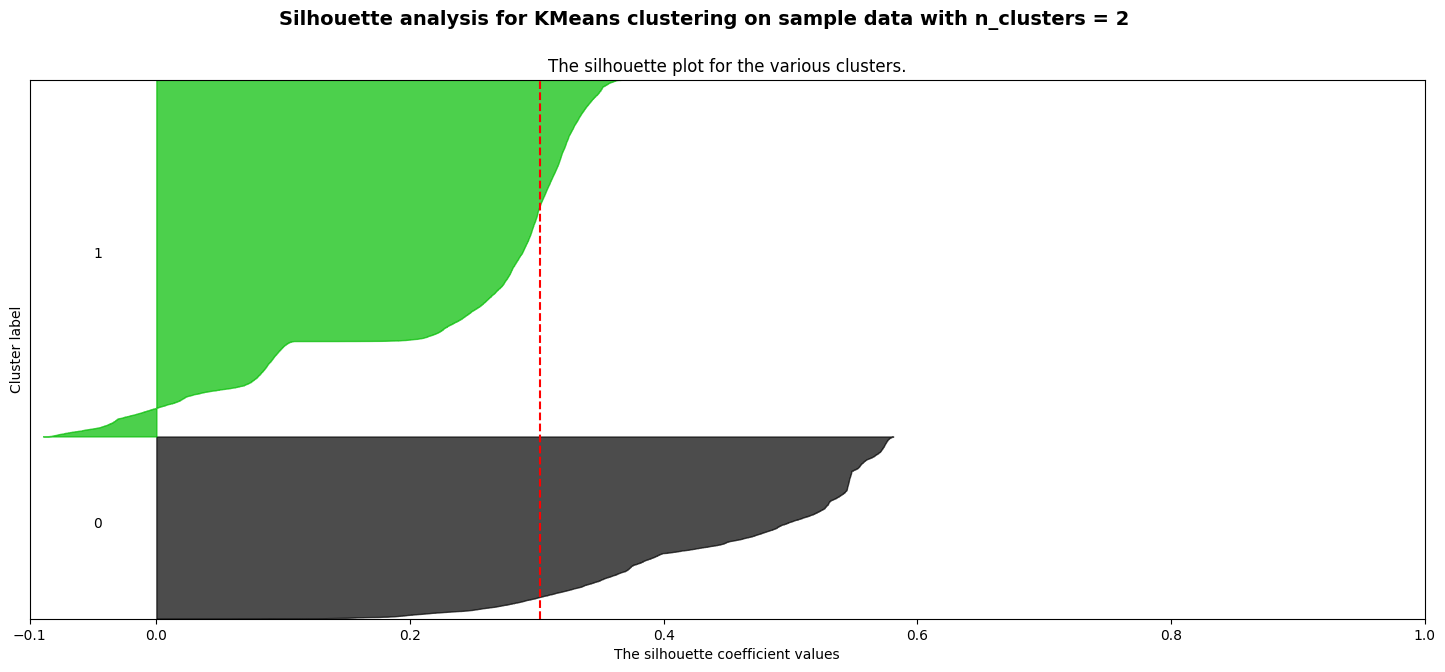

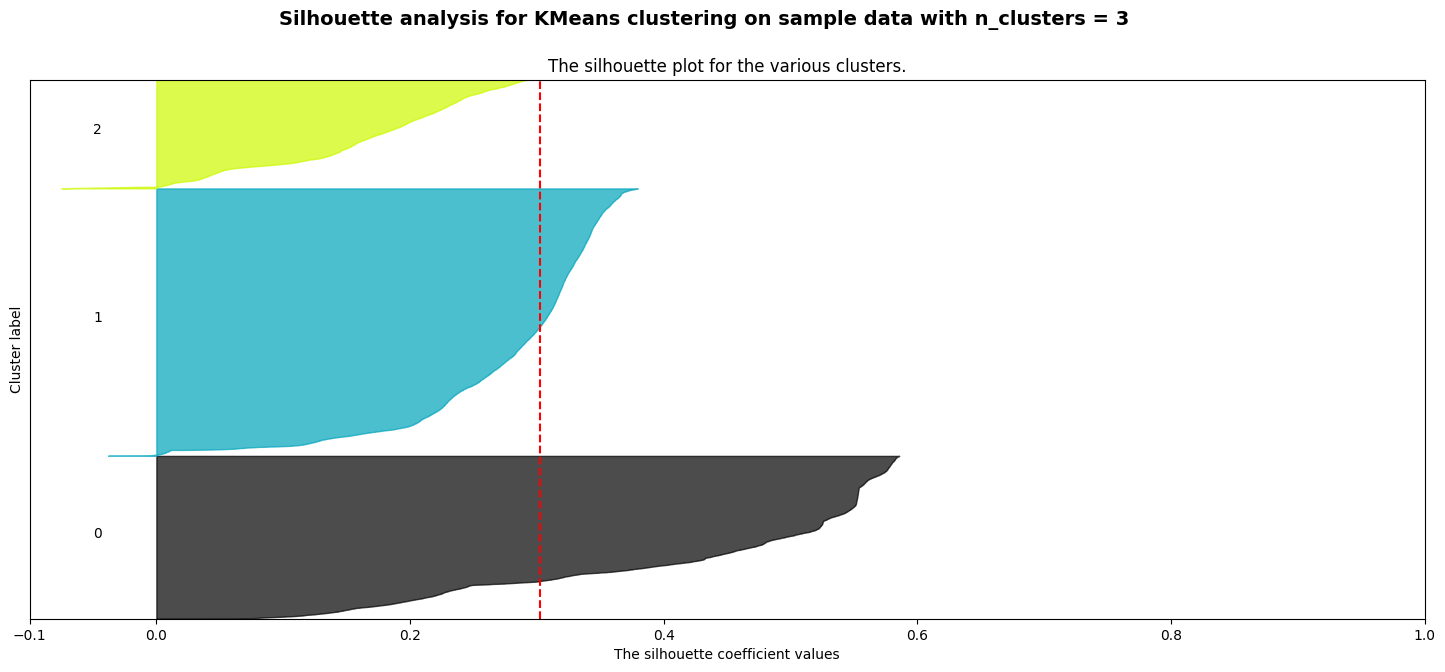

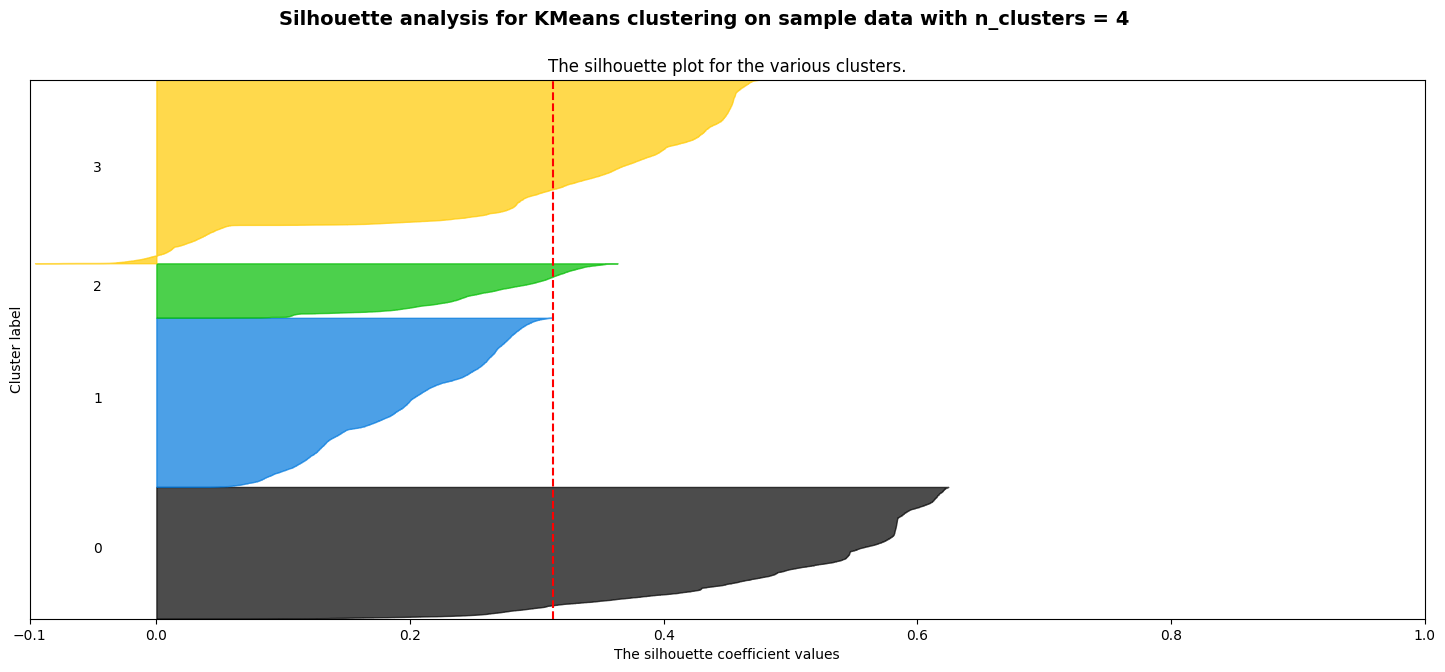

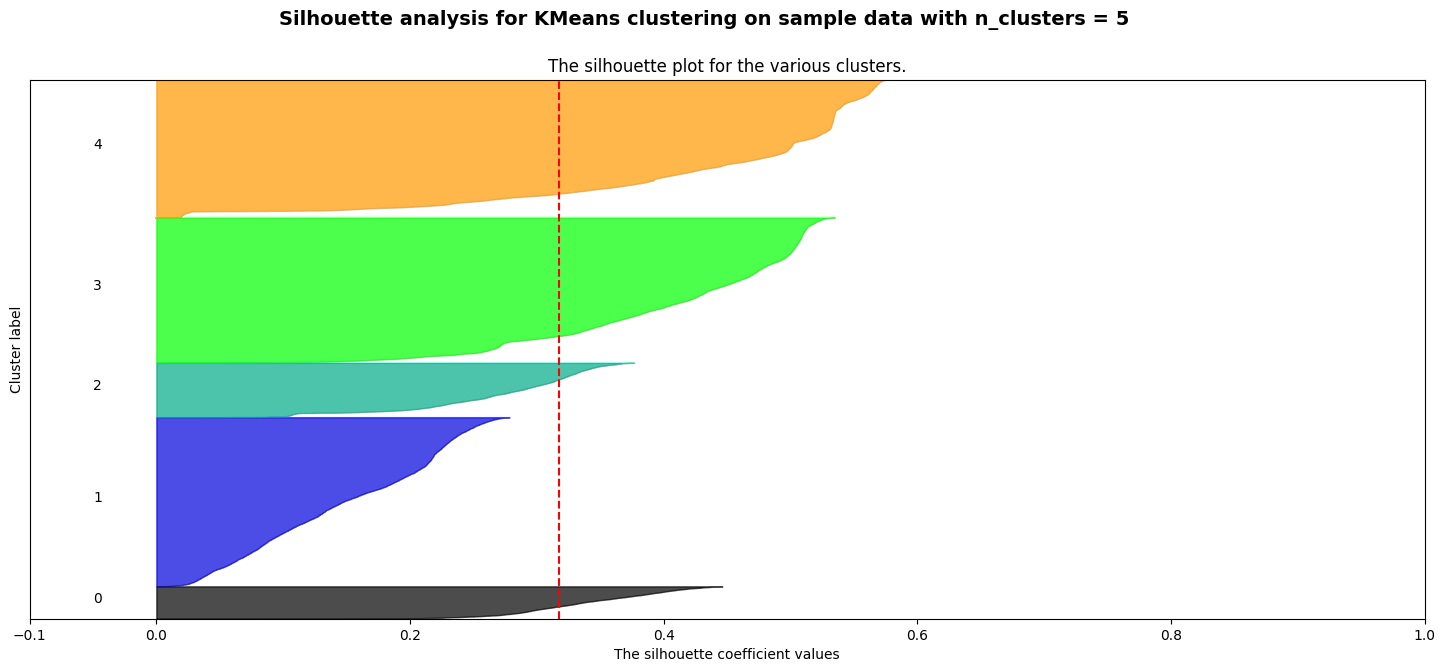

In [486]:
cluster_df = pd.read_csv(artifacts_dir / "clusters.csv")
silhouette_df = pd.read_csv(artifacts_dir / "silhouette.csv")
visualize.silhouette_plot(df=cluster_df, silhouette_df=silhouette_df)

## Benchmark

In [487]:
cleaned_df = pipe_fe[:9].transform(df)

In [488]:
plot_df

,customer_id,first_last,n_days
0,64f7d7dd7a59bba7168cc9c960a5c60e,days_since_first_order,2091
1,fa7c64efd5c037ff2abcce571f9c1712,days_since_first_order,2082
2,18923c9361f27583d2320951435e4888,days_since_first_order,2072
3,aa21f31def4edbdcead818afcdfc4d32,days_since_first_order,2054
4,668c6aac52ff54d4828ad379cdb38e7d,days_since_first_order,2053
...,...,...,...
92553,5b34391ec6fbc0f189cb8d3d88806199,days_since_last_order,1200
92554,198fd2f143f70b149344bcaf7eddee12,days_since_last_order,2976
92555,338b5c8ade4af1a562d55d4036710630,days_since_last_order,23952
92556,2115c065bfc1f3b39e4c87c202e80fa5,days_since_last_order,30888


C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\1555142899.py:14: UserWarning:

The figure layout has changed to tight



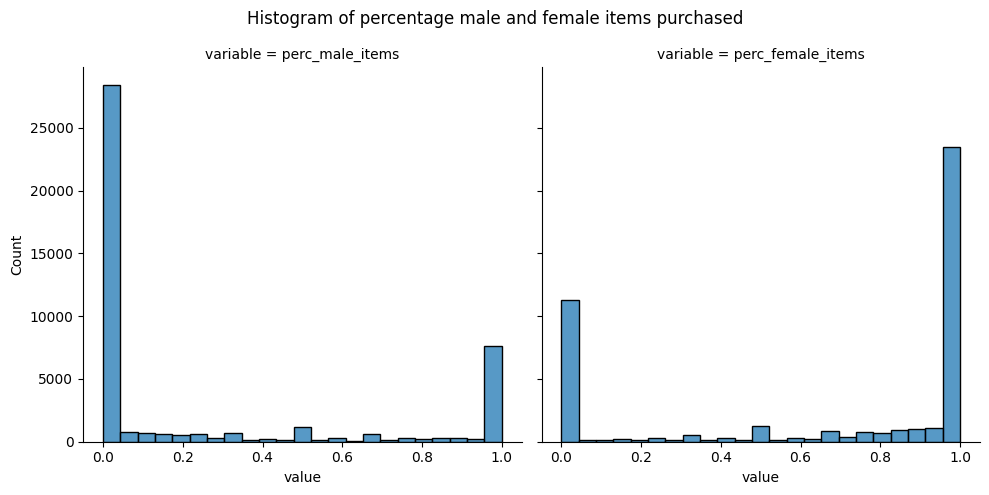

In [489]:
plot_df = pd.melt(
    frame=cleaned_df,
    value_vars=["perc_male_items", "perc_female_items"],
)

fg = sns.displot(
    data=plot_df,
    x="value",
    col="variable",
    kind="hist",
    aspect=1,
)
fg.fig.suptitle("Histogram of percentage male and female items purchased")
plt.tight_layout()

In [490]:
threshold = 0.5
thresholded_df = (
    cleaned_df
    .assign(thresholded_gender = lambda df: np.where(df.loc[:, "perc_male_items"] > threshold, "mostly_male_items",
                                            np.where(df.loc[:, "perc_female_items"] > threshold, "mostly_female_items",
                                                     "mostly_unisex_items")))
)
thresholded_df.loc[:, ["perc_male_items", "perc_female_items", "perc_unisex_items", "thresholded_gender"]]

,perc_male_items,perc_female_items,perc_unisex_items,thresholded_gender
0,0.040000,0.920000,0.040000,mostly_female_items
1,0.000000,0.923077,0.076923,mostly_female_items
2,0.019737,0.967105,0.013158,mostly_female_items
3,0.000000,0.000000,1.000000,mostly_unisex_items
5,0.000000,1.000000,0.000000,mostly_female_items
...,...,...,...,...
46274,0.050000,0.900000,0.050000,mostly_female_items
46275,0.105263,0.684211,0.210526,mostly_female_items
46276,0.000000,1.000000,0.000000,mostly_female_items
46277,0.000000,1.000000,0.000000,mostly_female_items


[Text(0.5, 1.0, 'Count of users whose purchases are over 50% of the category.')]

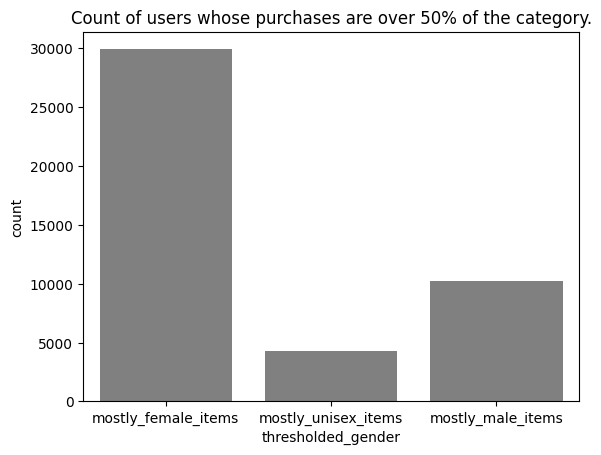

In [491]:
fg = sns.countplot(data=thresholded_df,
                   x="thresholded_gender",
                   color="grey",)
fg.set(title="Count of users whose purchases are over 50% of the category.")

## Histograms

In [492]:
merged_df = pd.merge(left=cleaned_df,
                   right=cluster_df,
                   on="customer_id",
                   how="left")
merged_df

,coupon_discount_applied,days_since_last_order,average_discount_used,customer_id,days_since_first_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,...,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,average_discount_onoffer,revenue,perc_male_items,perc_female_items,perc_unisex_items,items_per_order,days_between_first_and_last_order,rev_per_item,rev_per_order,perc_cancels,n_clusters_2,n_clusters_3,n_clusters_4,n_clusters_5
0,248.65,653.0,0.358448,64f7d7dd7a59bba7168cc9c960a5c60e,2091,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,...,0,0,17,0,0,0,0,1,0,16,4554.39,0.3364,6946.34,0.040000,0.920000,0.040000,2.941176,1438.0,138.926800,408.608235,0.000000,1,1,3,3
1,0.00,22.0,0.140410,fa7c64efd5c037ff2abcce571f9c1712,2082,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,...,0,12,1,0,0,0,0,9,0,4,629.03,0.1404,5329.28,0.000000,0.923077,0.076923,2.000000,2060.0,204.972308,409.944615,0.000000,0,2,2,2
2,107.92,6.0,0.189973,18923c9361f27583d2320951435e4888,2072,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,...,0,10,61,0,0,0,0,11,0,60,6269.71,0.1851,14133.87,0.019737,0.967105,0.013158,2.140845,2066.0,92.985987,199.068592,0.028169,1,1,1,1
3,90.90,2050.0,0.387567,aa21f31def4edbdcead818afcdfc4d32,2054,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,...,0,0,2,0,0,0,0,0,0,2,0.00,0.0000,143.64,0.000000,0.000000,1.000000,1.000000,4.0,71.820000,71.820000,0.000000,1,1,1,1
4,0.00,2044.0,0.000000,5f1e0812c41be939d971e34236d4de5b,2044,N,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1,0.00,0.0000,63.59,0.000000,1.000000,0.000000,1.000000,0.0,63.590000,63.590000,0.000000,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44497,1791.33,50.0,0.352567,5b34391ec6fbc0f189cb8d3d88806199,1372,N,18,40,0,0,0,7,2,5,1,1,0,0,36,2,2,17,7,1,8,...,0,1,11,0,6,0,0,15,0,3,141.96,0.0091,3822.84,0.050000,0.900000,0.050000,2.222222,1322.0,95.571000,212.380000,0.000000,1,0,3,0
44498,240.62,124.0,0.209202,198fd2f143f70b149344bcaf7eddee12,646,Y,19,19,1,6,1,2,2,4,1,1,0,0,13,2,4,5,5,2,1,...,0,0,12,0,7,0,13,6,0,0,242.87,0.1210,1383.68,0.105263,0.684211,0.210526,1.000000,522.0,72.825263,72.825263,0.052632,1,2,1,1
44499,0.00,998.0,0.150000,338b5c8ade4af1a562d55d4036710630,1308,N,2,2,0,0,1,2,1,0,1,0,0,0,2,0,0,2,0,0,0,...,0,0,2,0,0,0,0,0,0,2,150.00,0.1500,521.81,0.000000,1.000000,0.000000,1.000000,310.0,260.905000,260.905000,0.000000,1,1,3,3
44500,254.95,1287.0,0.320760,2115c065bfc1f3b39e4c87c202e80fa5,1410,Y,14,15,0,2,0,1,2,7,1,0,0,0,15,0,0,13,0,0,0,...,0,7,6,0,1,0,0,0,0,14,258.50,0.1824,712.29,0.000000,1.000000,0.000000,1.071429,123.0,47.486000,50.877857,0.000000,1,1,1,1


In [493]:
n_clusters_col = "n_clusters_2"
value_vars = ["male_items", "female_items"]
value_vars = ["perc_male_items", "perc_female_items"]

In [494]:
merged_df.groupby(n_clusters_col)[value_vars].mean()

,perc_male_items,perc_female_items
n_clusters_2,,
0,0.271262,0.652067
1,0.240630,0.677654


In [495]:
plot_df = pd.melt(
    frame=merged_df,
    id_vars=[n_clusters_col],
    value_vars=value_vars,
)
plot_df

,n_clusters_2,variable,value
0,1,perc_male_items,0.040000
1,0,perc_male_items,0.000000
2,1,perc_male_items,0.019737
3,1,perc_male_items,0.000000
4,1,perc_male_items,0.000000
...,...,...,...
88999,1,perc_female_items,0.900000
89000,1,perc_female_items,0.684211
89001,1,perc_female_items,1.000000
89002,1,perc_female_items,1.000000


C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\477215891.py:18: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\477215891.py:18: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\477215891.py:18: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\.conda\envs\bayesian\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\Roger\AppData\Local\Temp\ipykernel_24040\477215891.py:18: UserWarning:

The figure layout has ch

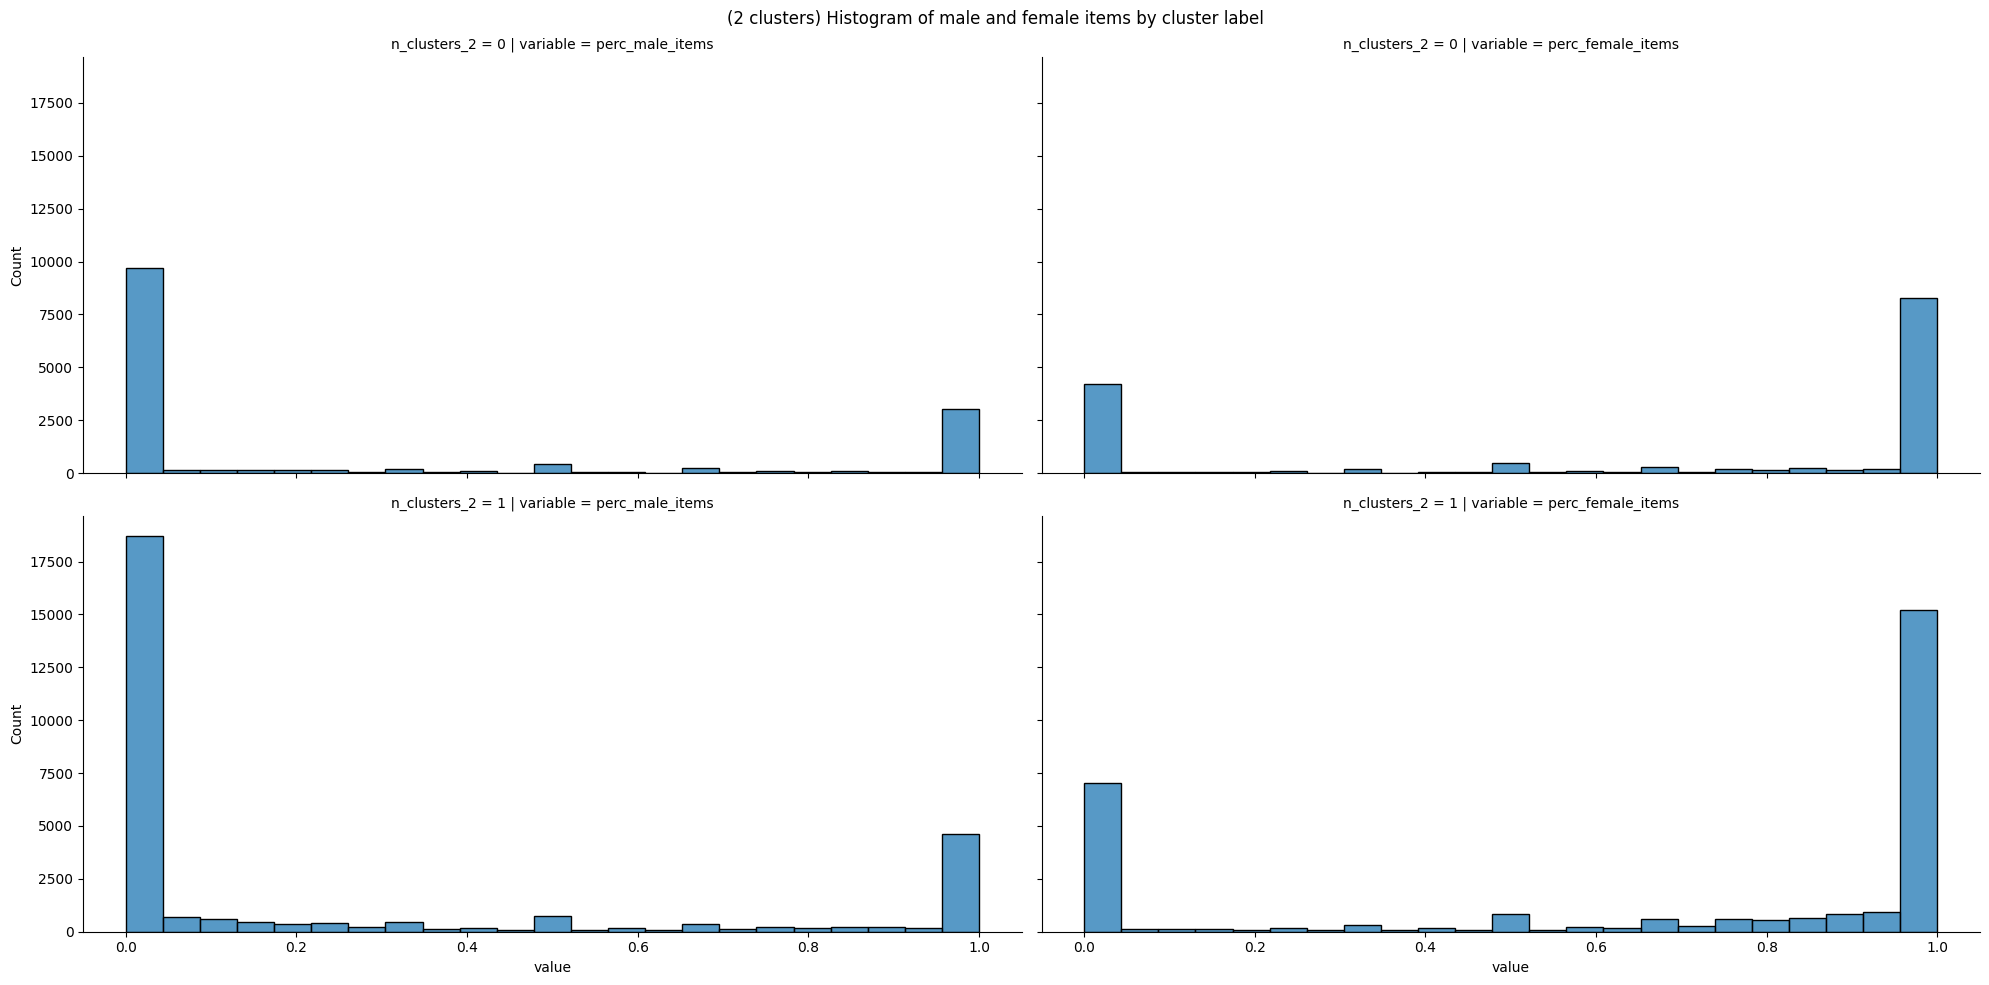

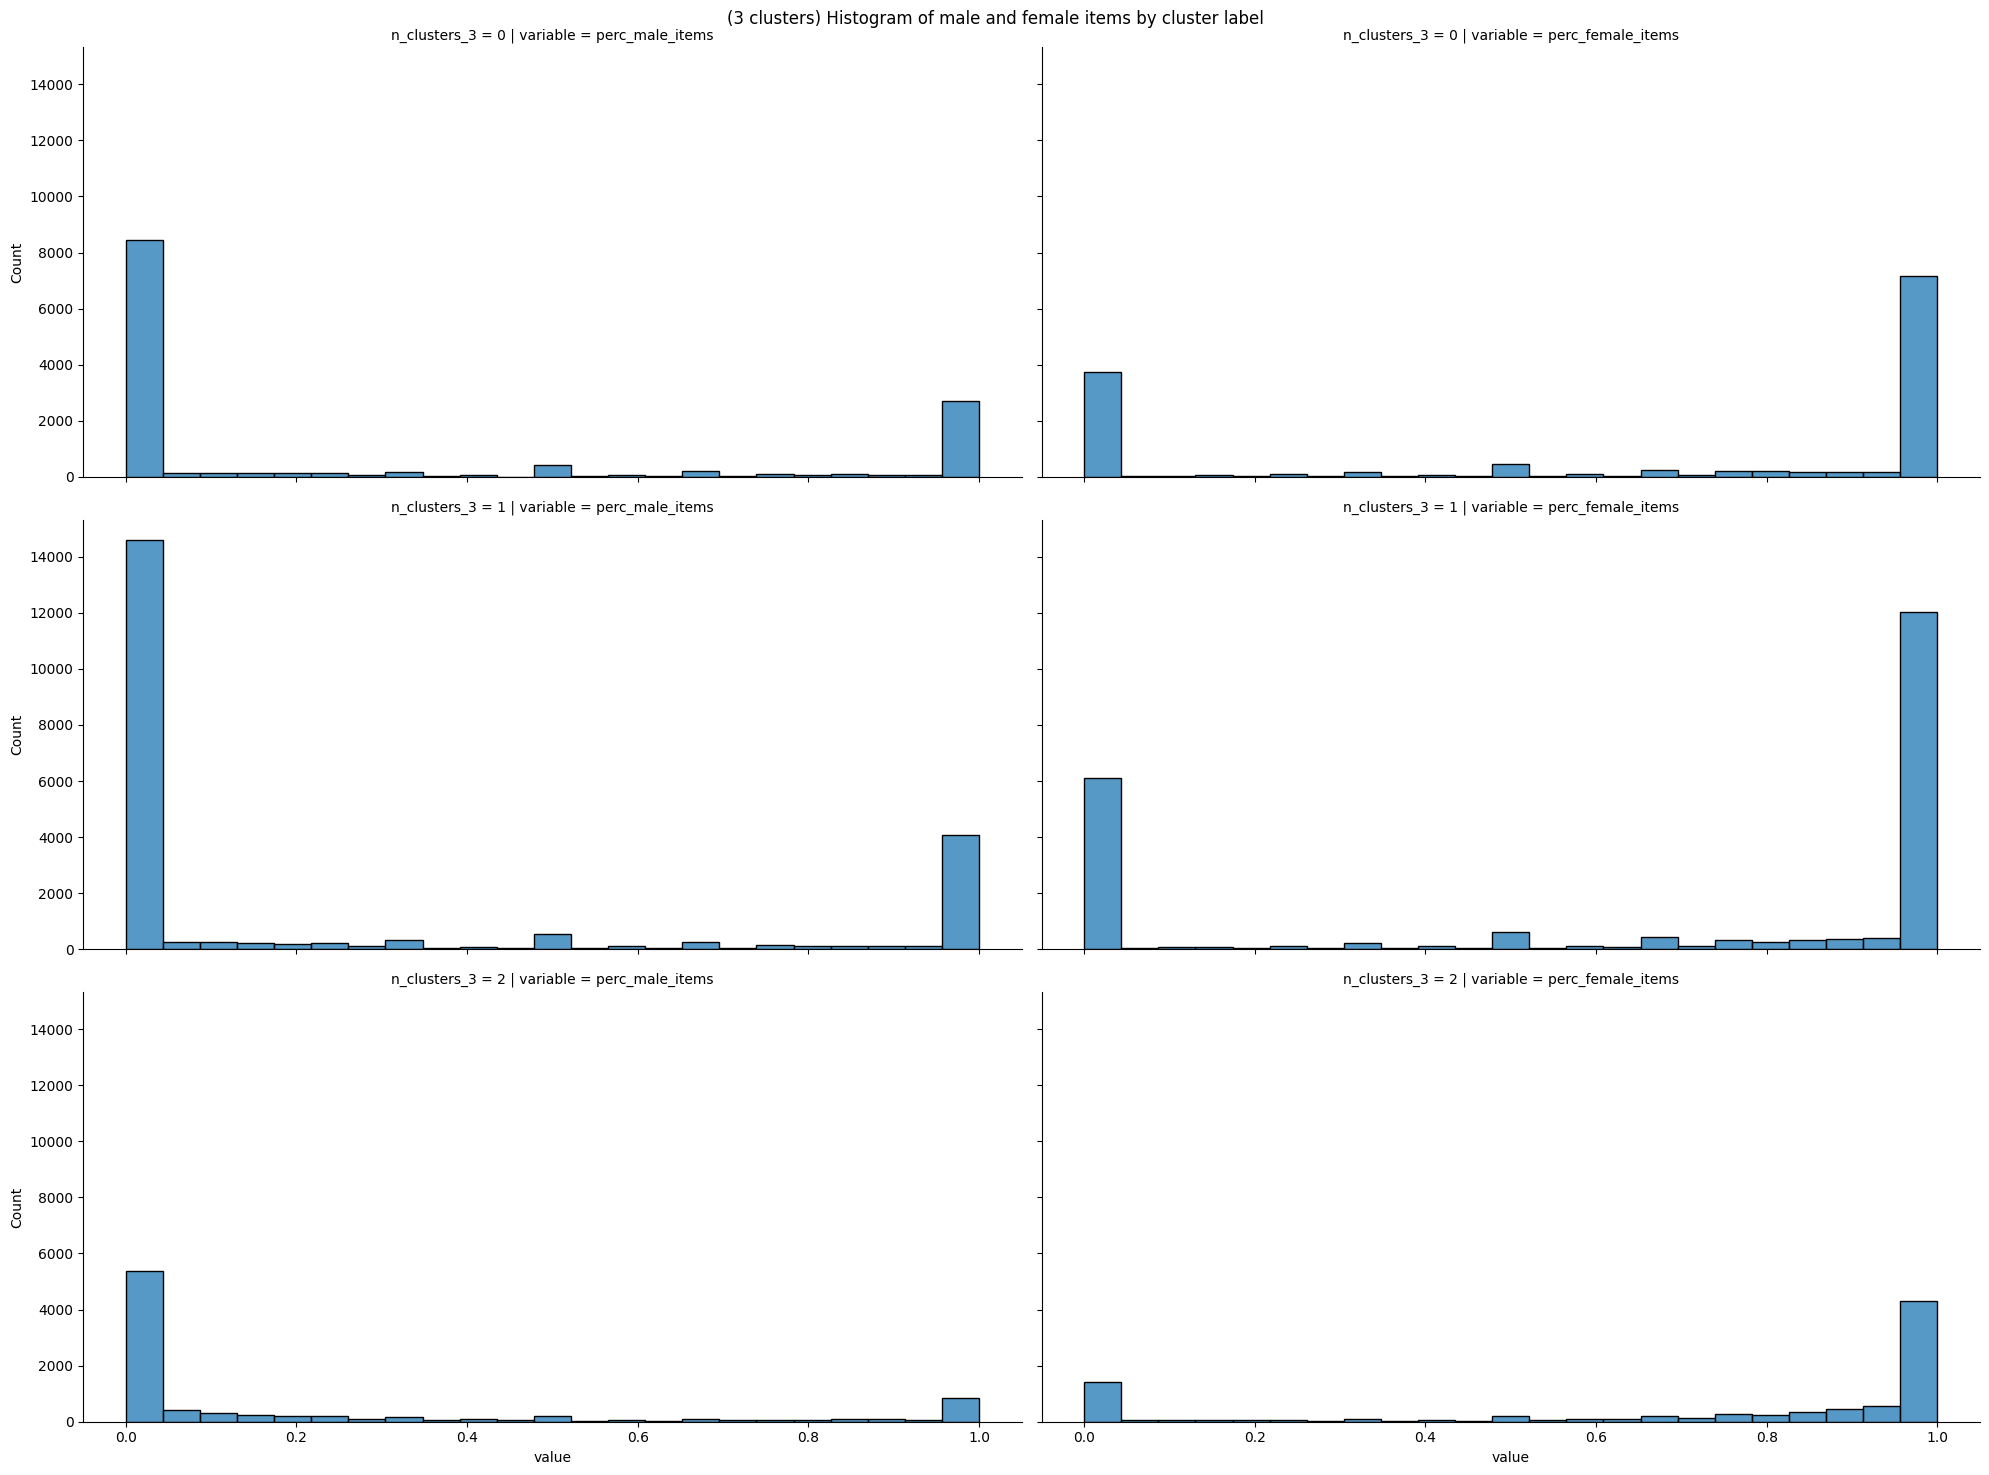

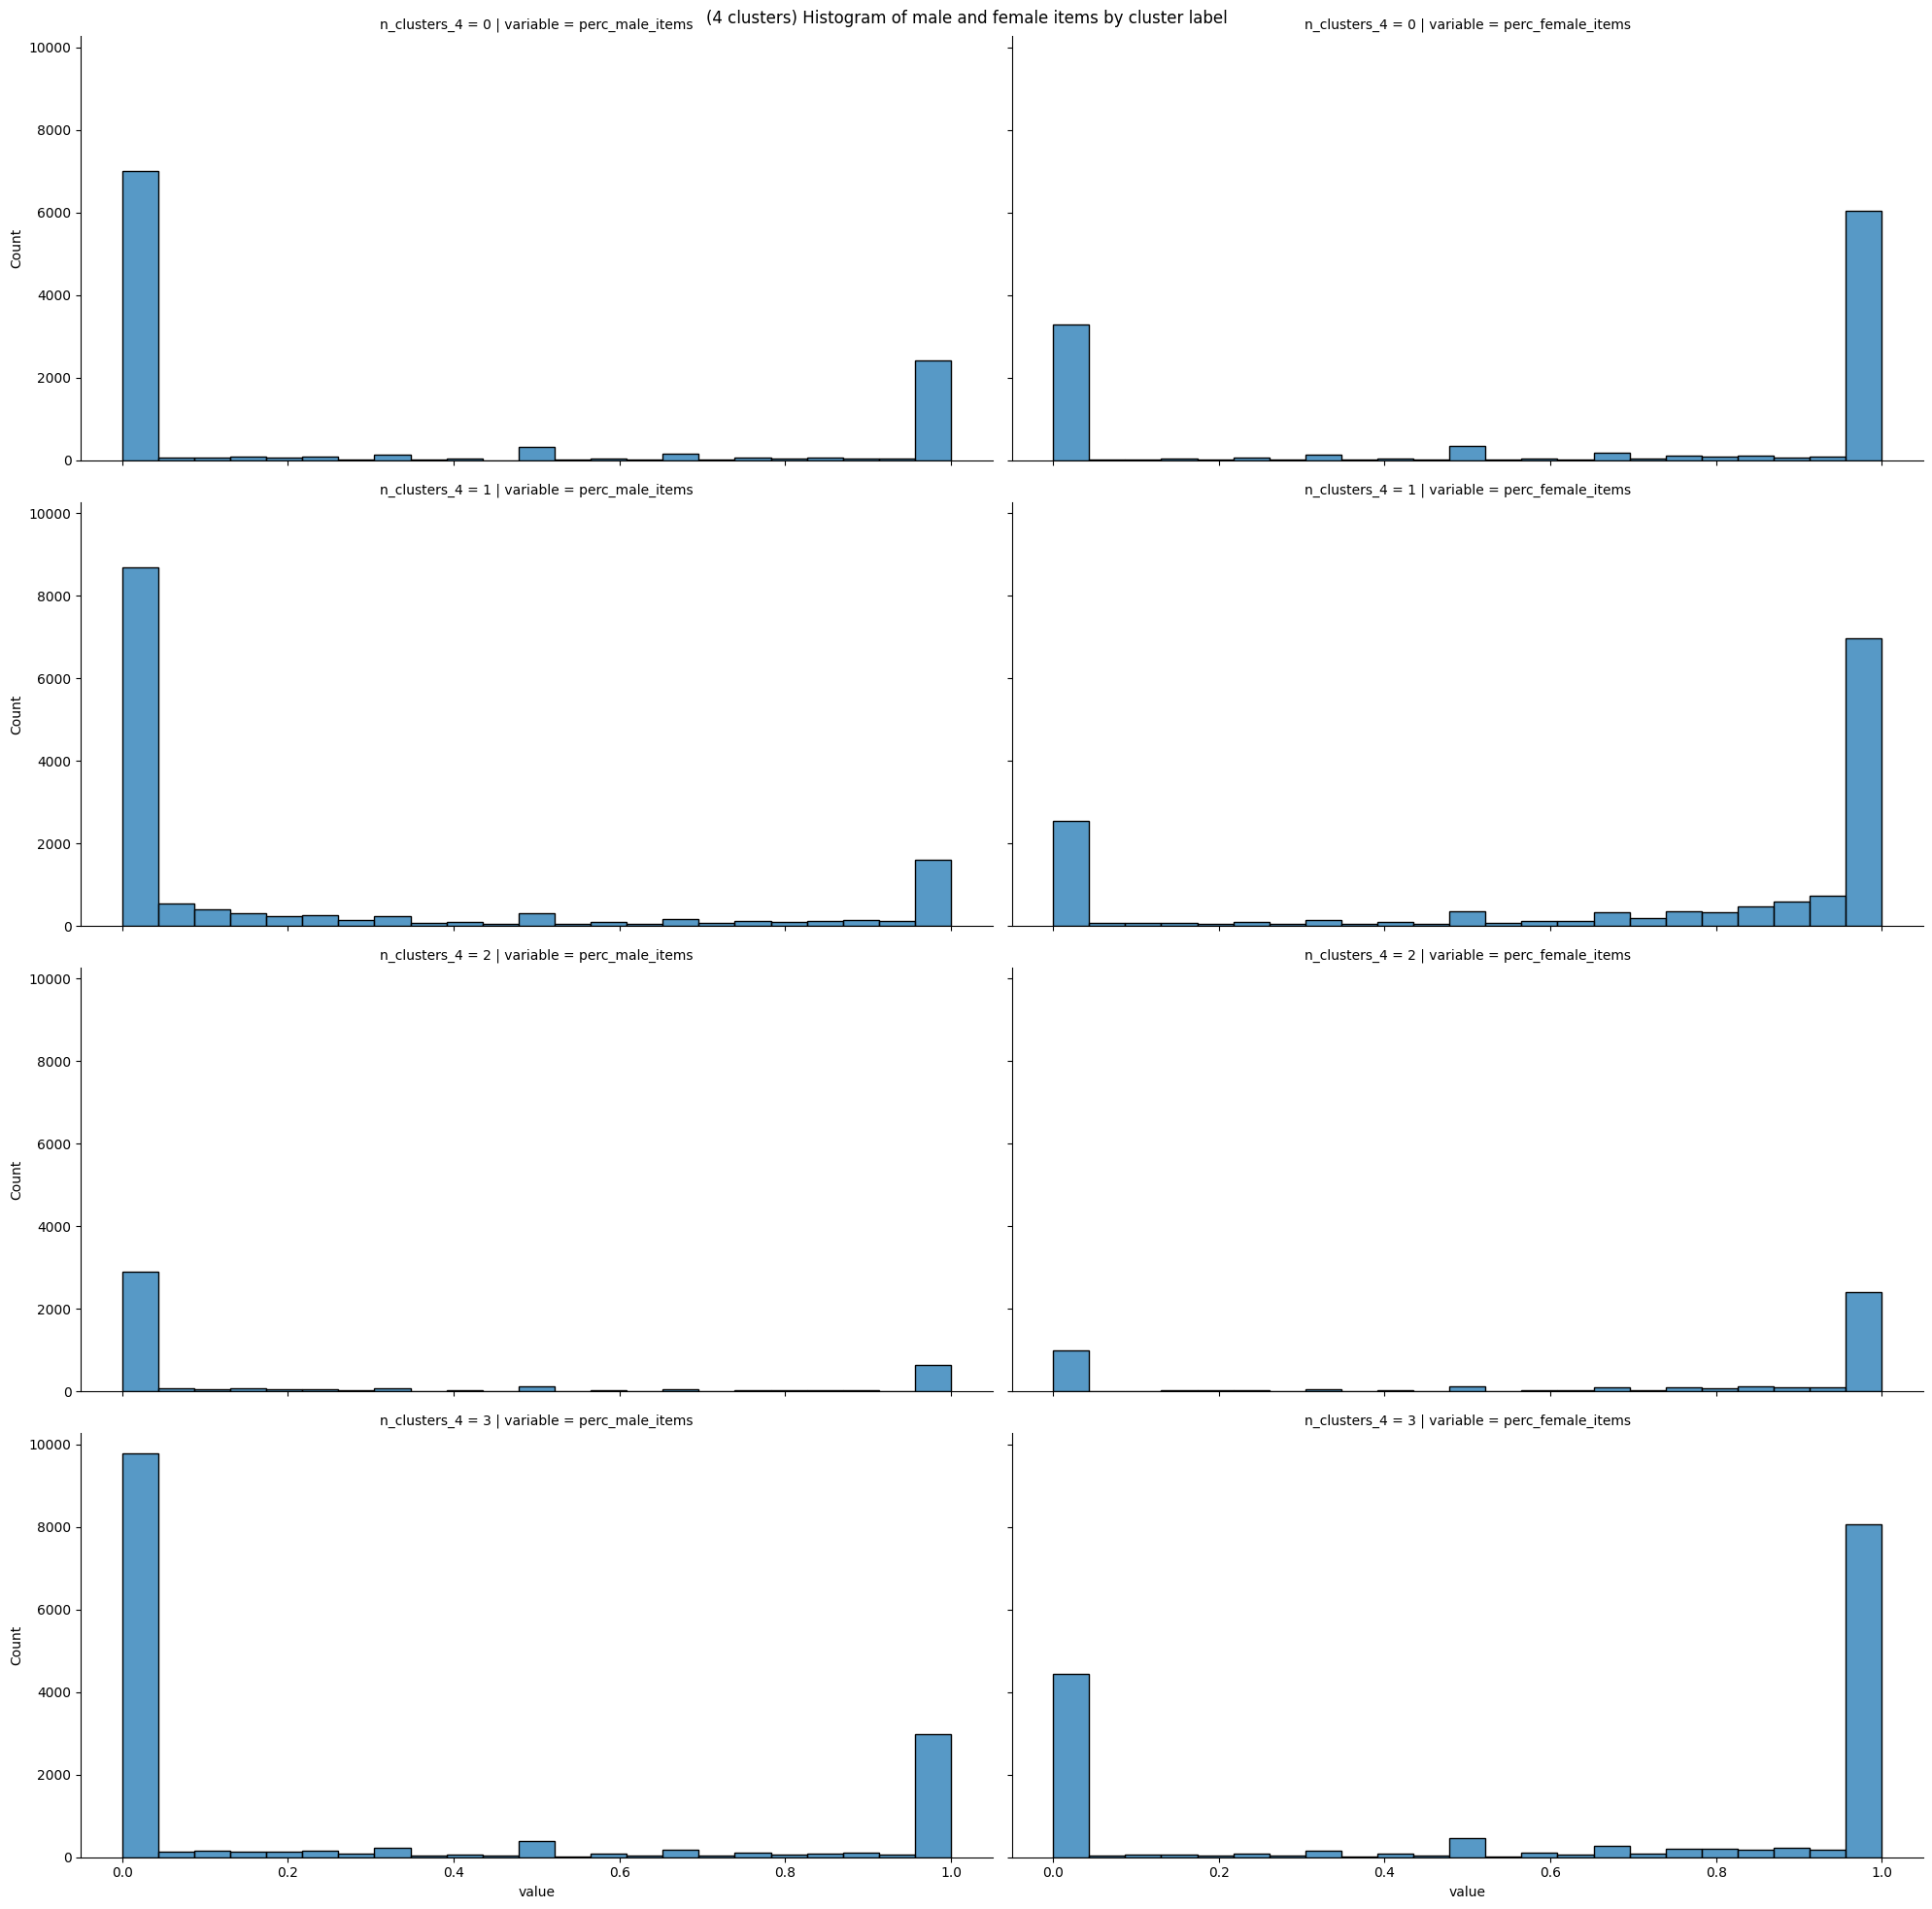

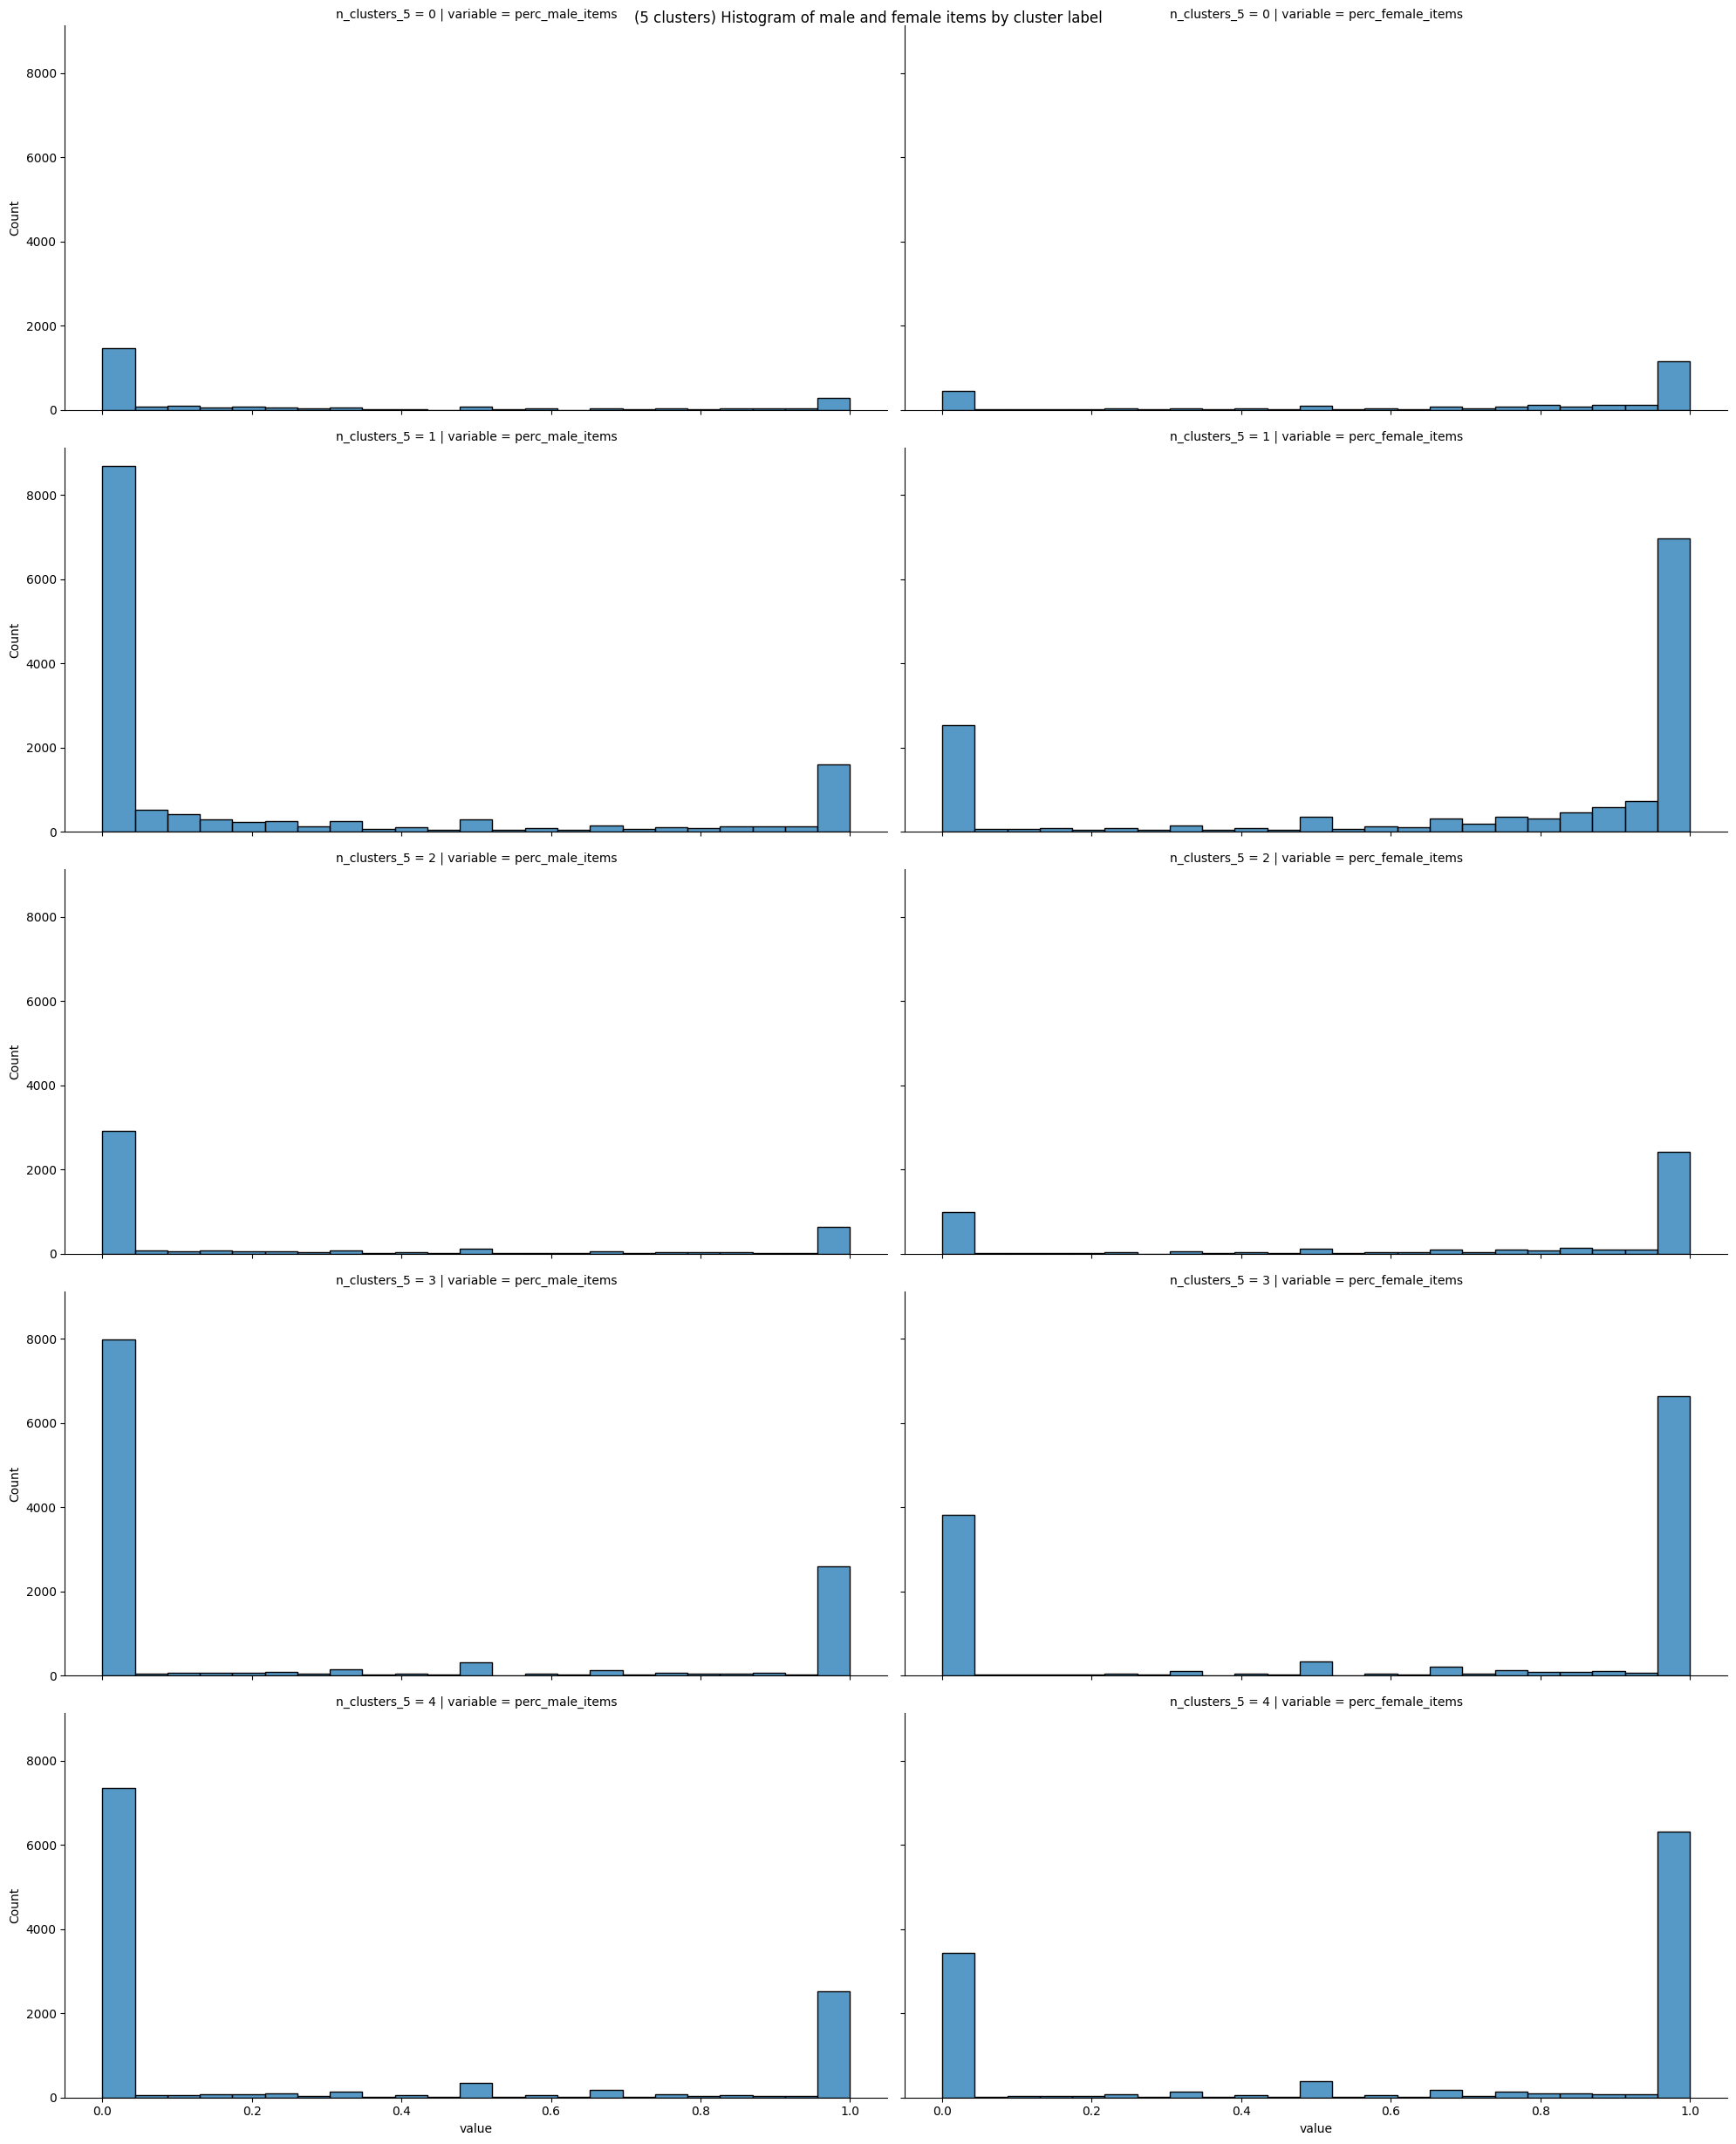

In [496]:
for col in cluster_df.iloc[:, 1:].columns:
    n_clusters = col.split("_")[-1]
    plot_df = pd.melt(
        frame=merged_df,
        id_vars=[col],
        value_vars=value_vars,
    )

    fg = sns.displot(
        data=plot_df,
        x="value",
        col="variable",
        row=col,
        kind="hist",
        aspect=2,
    )
    fg.fig.suptitle(f"({n_clusters} clusters) Histogram of male and female items by cluster label")
    plt.tight_layout()

The above histograms show that, for all models, each cluster contains groups of people who purchase mostly female items **as well as** those who purchase mostly male items. This means that the model has not learned to separate the data according to what we need.

## Scatterplots

In [497]:
# Make the clusters into strings
pred_df = pd.read_csv(artifacts_dir / "clusters.csv")
new_dtypes = {col: str for col in pred_df.drop(columns=["customer_id"]).columns}
new_dtypes

{'n_clusters_2': str,
 'n_clusters_3': str,
 'n_clusters_4': str,
 'n_clusters_5': str}

In [498]:
merged_df = merged_df.astype(new_dtypes)

In [499]:
import plotly.express as px
import solara

pred_columns = pred_df.drop(columns=["customer_id"]).columns.tolist()
axis_columns = merged_df.drop(columns=pred_columns).columns.tolist()
x_axis = solara.reactive("perc_female_items")
y_axis = solara.reactive("perc_male_items")
z_axis = solara.reactive("revenue")
model_selector = solara.reactive("n_clusters_2")
bool_values = ["log x", "log y"]
log_axes = solara.reactive([])

color_map = {
    "0": "dark blue",
    "1": "orange",
    "2": "green",
    "3": "red",
    "4": "purple",
    "5": "gray",
}

@solara.component
def Page():
    # fig = px.scatter(
    #     data_frame=merged_df, 
    #     x=x_axis.value, 
    #     y=y_axis.value, 
    #     color=model_selector.value
    # )
    fig = px.scatter_3d(
        data_frame=merged_df,
        x=x_axis.value, 
        y=y_axis.value, 
        z=z_axis.value, 
        log_x=True if "log x" in log_axes.value else False,
        log_y=True if "log y" in log_axes.value else False,
        color=model_selector.value,
        color_discrete_map=color_map,
        height=1000,
    )
    fig.update_traces(marker={"size": 3})
    solara.Select(label="X-axis", values=axis_columns, value=x_axis)
    solara.Select(label="Y-axis", values=axis_columns, value=y_axis)
    solara.Select(label="Z-axis", values=axis_columns, value=z_axis)
    solara.Select(label="Model", values=pred_columns, value=model_selector)
    with solara.Card("Log Axes"):
        solara.ToggleButtonsMultiple(value=log_axes, values=bool_values)

Page()

Cannot show ipywidgets in text